# Цель: 
Исследовать и анализировать временные ряды данных по объему продаж и средней дневной выручке для получения полезных инсайтов и разработки моделей прогнозирования.

# Задачи:

1. Анализ данных рядов:
   - Изучить структуру и формат данных для объема продаж и средней дневной выручки;
   - Проверить наличие и обработать пропущенные значения или аномальные данные.

2. Визуализация и предварительный анализ:
   - Построить графики временных рядов для визуализации динамики объема продаж и средней дневной выручки;
   - Изучить основные характеристики рядов, такие как тренды, сезонность, выбросы и цикличность.

3. Стационарность и преобразование данных:
   - Проверить стационарность рядов, проведя тест на единичные корни или использовав другие методы;
   - Применить декомпозицию временных рядов для выделения тренда, сезонности и остатков.

4. Моделирование и прогнозирование:
   - Применить различные модели машинного обучения, такие как линейная регрессия, случайный лес, градиентный бустинг, нейронные сети или другие регрессионные модели для построения прогнозов объема продаж и средней дневной выручки;
   - Оценить модели на основе метрик качества прогнозирования (например, RMSE или MAPE);
   - Сравнить результаты различных моделей и определить, какая модель дает наилучшие прогнозные результаты для данных временных рядов.

In [1]:
import io
import itertools
import warnings

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.offline as pyo
import pyspark

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.iolib.table import SimpleTable
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from pandas.core.frame import DataFrame
from pandas import pandas as pd
from pyspark.sql import SparkSession, functions as f
import scipy.fftpack as fft
from sktime.utils.plotting import plot_series
import seaborn as sns

warnings.filterwarnings('ignore')

RND = 21

pyo.init_notebook_mode(connected=True)

## Db connection
***

In [2]:
spark = (
    SparkSession.builder
    .appName('SSession')
    .master('local[*]')
    .config("spark.driver.memory", "2g") 
    .getOrCreate()
)
spark.sparkContext.setLogLevel('OFF')

spark

23/12/11 16:31:28 WARN Utils: Your hostname, shazy-latitude resolves to a loopback address: 127.0.1.1; using 192.168.1.76 instead (on interface wlan0)
23/12/11 16:31:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 16:31:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df_ord = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://111.111.1.11:1111/tbot_test") \
    .option("dbtable", "orders") \
    .option("user", "shazy") \
    .option("password", "1111") \
    .load()

In [4]:
df_prod = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://111.111.1.11:1111/tbot_test") \
    .option("dbtable", "products") \
    .option("user", "shazy") \
    .option("password", "1111") \
    .load()

In [5]:
df_buy = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://111.111.1.11:1111/tbot_test") \
    .option("dbtable", "buyers") \
    .option("user", "shazy") \
    .option("password", "1111") \
    .load()

Не указываем `'org.postgresql.Driver'` т.к. в корень спарка `jars` добавили JDBC postgresql driver `ver-42.6.0` напрямую

***

In [6]:
def jb_test(df):
    """ Тест Харки — Бера для определения номарльности распределения """
    row =  [u'JB(Статистика теста Харке-Бера)', u'p-value', u'skew(асимметрия)', u'kurtosis(эксцесс)']
    jb_test = jarque_bera(df)
    a = np.vstack([jb_test])
    itog = SimpleTable(a, row)
    return itog

In [7]:
def fuller_test(df):
    """ Обобщенный тест Дикки-Фуллера на наличие единичных корней """
    test = adfuller(df)
    
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    
    if test[0]> test[4]['5%']: 
        return 'Есть единичные корни, ряд не стационарен'
    else:
        return 'Единичных корней нет, ряд стационарен'

In [8]:
def plot_sason_tail(series: pd.core.series.Series) -> None:
    # Построение графика сезонной составляющей (хвосты за полследние 3 месяца)
    fig, axs = plt.subplots(figsize=(25, 12))
    
    decomposition = seasonal_decompose(series, period=30)
    seasonal = decomposition.seasonal.tail(30*3)
    
    plt.plot(seasonal)
    plt.xlabel('Time')
    plt.ylabel('Seasonal Component')
    plt.show()

In [9]:
def spec_plot(series: pd.core.series.Series) -> None:
    # Применение преобразования Фурье
    spectrum = fft.fft(series.values)
    
    # Вычисление модуля спектра
    amplitude = np.abs(spectrum)
    frequencies = fft.fftfreq(len(series))
    
    fig = px.line(x=frequencies, y=amplitude, title="Sorted Input")
    fig.update_layout(
        title="График спектра",
        xaxis_title="Frequency",
        yaxis_title="Amplitude",
    )
    fig.show(renderer='iframe')

In [10]:
def variance_plot(time_series: np.ndarray) -> None:
    variance = [i**2 for i in time_series]
    mean_level = np.mean(variance)
    
    plt.plot(range(len(variance)), variance)
    plt.axhline(y=mean_level, color='r', linestyle='--', label='Средний уровень')
    plt.xlabel('Период времени')
    plt.ylabel('Дисперсия')
    plt.title('График дисперсии временного ряда')
    plt.legend()
    plt.show()

In [11]:
def plot_seasonal_dec(dec_list: list) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(25, 15))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    for index, elem in enumerate(dec_list):
        decomposed_df = seasonal_decompose(elem, period=30)
        decomposed_df.seasonal.tail(30*12).plot(title='Seasonal '+legend_list[index]+' on year', ax=axs[index, 0])
        decomposed_df.seasonal['2022-12-01':'2023-01-01'].plot(title='Seasonal '+legend_list[index]+' during month', ax=axs[index, 1])
        del decomposed_df
        
    plt.show()

---

In [12]:
# Фильтрация строк в заданном временном промежутке
start_date = "2021-02-21"
end_date = "2022-01-11"
df_filtered = df_ord.filter((f.col("time") >= start_date) & (f.col("time") <= end_date))

df_filtered.show()

+------+---------+--------------------+--------------------+
|    id|buyers_id|            item_ids|                time|
+------+---------+--------------------+--------------------+
|600004|   136193|[48, 814, 717, 16...|2021-11-15 04:59:...|
|600006|   758956|[778, 1810, 1204,...|2021-02-26 21:07:...|
|600013|   967263|[242, 1280, 1660,...|2021-11-23 19:16:...|
|600036|   439473|[200, 136, 1678, ...|2022-01-01 07:17:...|
|600039|   451513|[214, 2080, 577, ...|2021-05-12 17:47:...|
|600044|    73630|[1744, 841, 47, 1...|2021-05-28 09:20:...|
|600048|   278423|[1231, 1197, 711,...|2021-07-19 22:05:...|
|600052|   541970|[1691, 903, 539, ...|2021-03-07 20:18:...|
|600061|   127901|[1989, 244, 780, ...|2021-05-14 13:32:...|
|600062|   605973|[635, 692, 284, 1...|2021-12-20 17:34:...|
|600076|   344724|[1032, 808, 1991,...|2021-02-26 10:12:...|
|600080|   410318|[1076, 1889, 857,...|2021-10-22 11:17:...|
|600095|   605383|[800, 1478, 168, ...|2021-08-03 13:00:...|
|600100|   938433|[235, 

### Расскрываем array

In [13]:
data = df_ord.withColumn("item_id", f.explode(df_ord["item_ids"])).drop('item_ids')

df_prod = df_prod.withColumnRenamed("id", "prod_id")
data = data.join(df_prod, data.item_id == df_prod.prod_id, "left").drop('prod_id')

In [14]:
df = data.withColumn("date", f.date_format(f.col("time"), "yyyy-MM-dd")).select('date', 'price')

In [15]:
df_c = df.groupby('date').count().toPandas()

In [16]:
df_m = df.groupby('date').avg('price').withColumnRenamed('avg(price)', 'avg_rev').toPandas()

## Автокорреляционная функция (ACF):

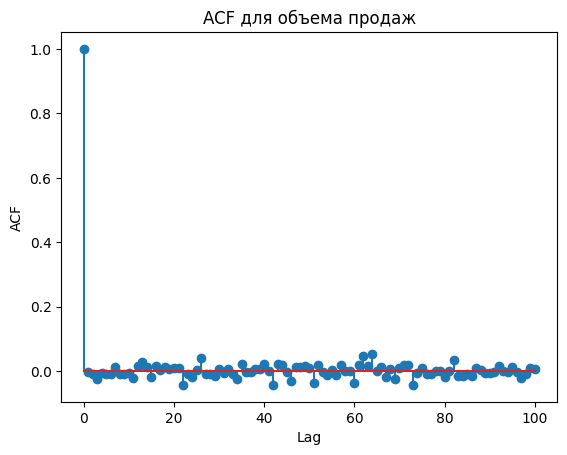

In [17]:
acf = sm.tsa.acf(df_c['count'], nlags=100)

plt.title('ACF для объема продаж')
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

около-нулевые автокорреляции при всех лагах

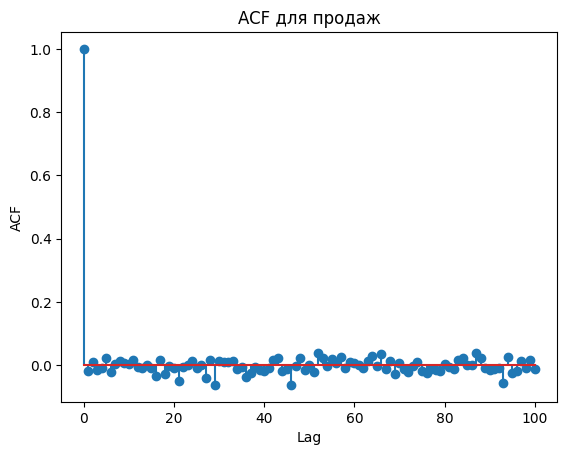

In [18]:
acf = sm.tsa.acf(df_m['avg_rev'], nlags=100)

plt.title('ACF для продаж')
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

около-нулевые автокорреляции при всех лагах

### Спектральный анализ

In [19]:
spec_plot(df_c['count'])

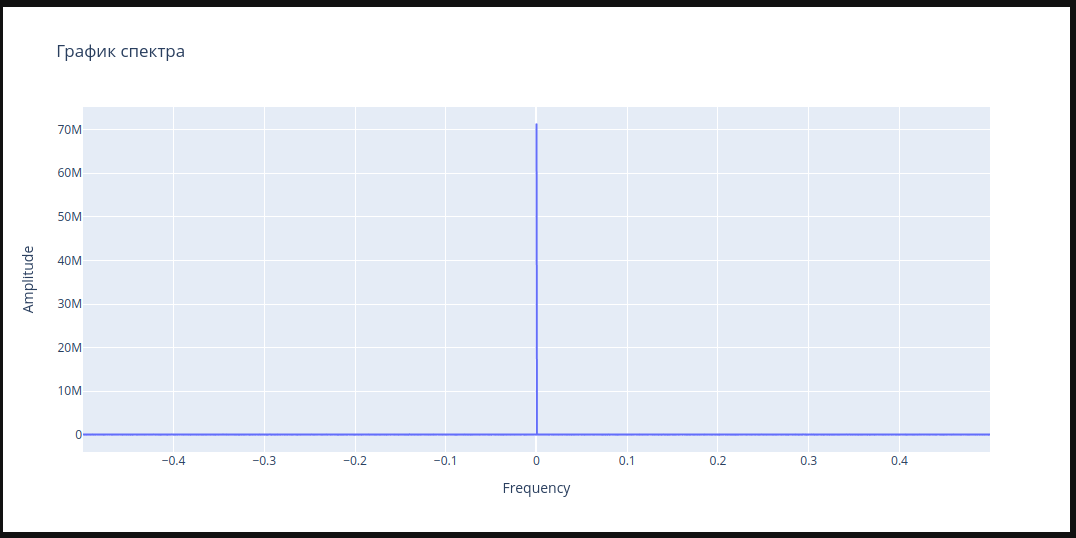
Основной пик на нулевой частоте указывает на постоянную составляющую в ряде, которая представляет собой среднее значение ряда.

Посмотрим на отцентрованный ряд

In [20]:
df_c_centered = df_c['count'] - df_c['count'].mean()

spec_plot(df_c_centered)

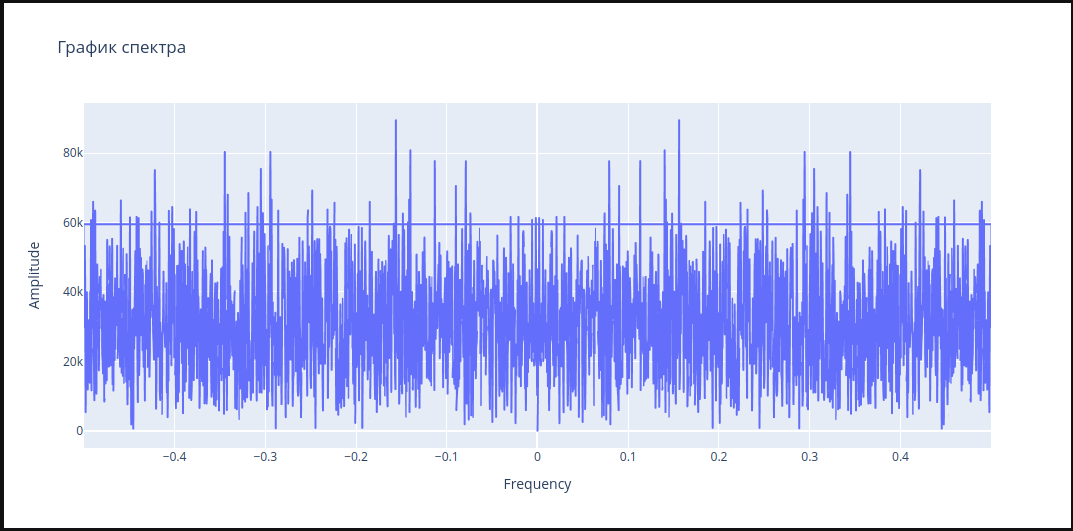

In [21]:
spec_plot(df_m['avg_rev'])

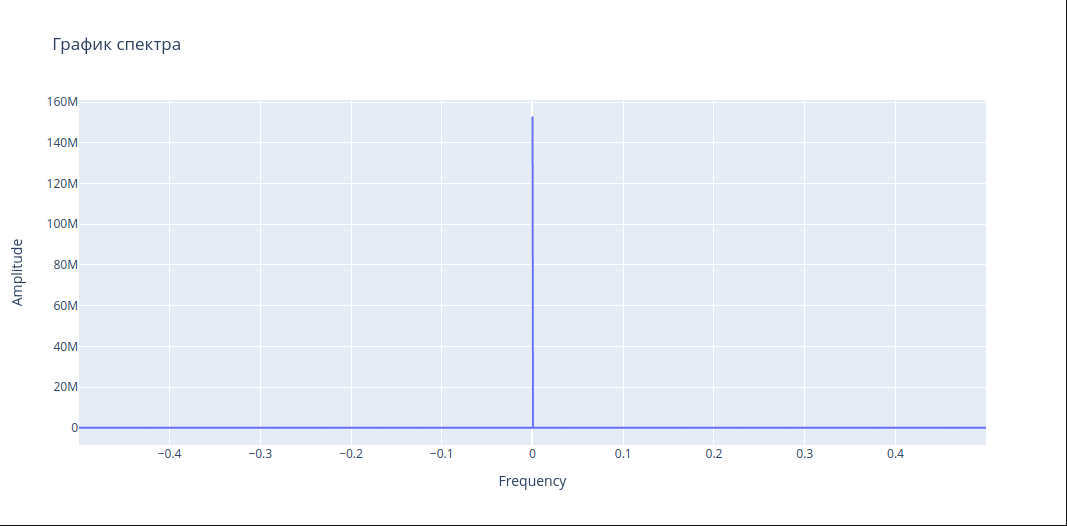
Основной пик на нулевой частоте указывает на постоянную составляющую в ряде, которая представляет собой среднее значение ряда.

Посмотрим на отцентрованный ряд

In [22]:
df_m_centered = df_m['avg_rev'] - df_m['avg_rev'].mean()

spec_plot(df_m_centered)

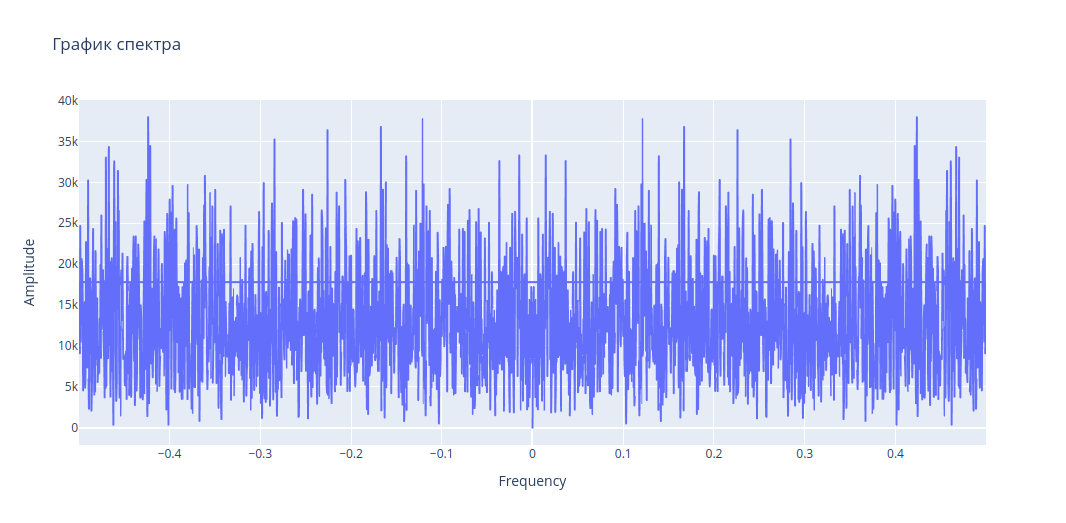

### Дисперсия

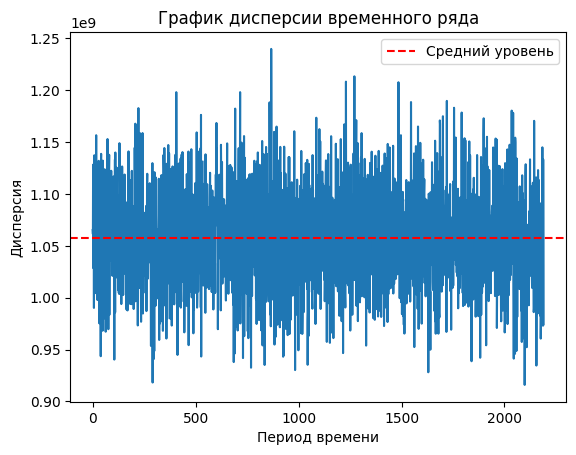

In [23]:
variance_plot(df_c['count'].values)

График дисперсии показывает случайное изменение значений вокруг некоторого среднего уровня, можем сделать вывод, что дисперсия остается постоянной со временем.

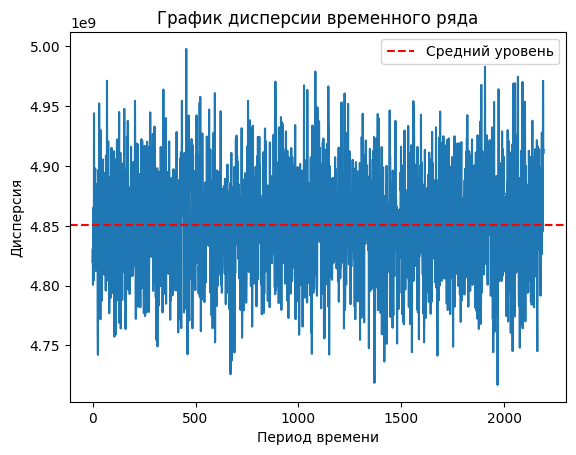

In [24]:
variance_plot(df_m['avg_rev'].values)

График дисперсии показывает случайное изменение значений вокруг некоторого среднего уровня, можем сделать вывод, что дисперсия остается постоянной со временем.

---
# Промежуточный вывод
## Объем продаж:
* Около-нулевые автокорреляции при **ВСЕХ** лагах;
* **ПОСТОЯННАЯ** составляющая в ряде, которая представляет собой среднее значение ряда;
* Дисперсия остается **ПОСТОЯННОЙ** со временем.

Итак, на основе представленных признаков можно сделать вывод, что мы имеем дело с белым шумом. Белый шум характеризуется отсутствием автокорреляции при всех лагах, наличием постоянной составляющей в виде среднего значения ряда и постоянной дисперсией со временем. Эти характеристики совпадают с определением белого шума.

## Средняя дневная выручка:
* Около-нулевые автокорреляции при **ВСЕХ** лагах;
* **ПОСТОЯННАЯ** составляющая в ряде, которая представляет собой среднее значение ряда;
* Дисперсия остается **ПОСТОЯННОЙ** со временем.

Исходя из определения белого шума, отсутствием автокорреляции при всех лагах, наличие постоянной составляющей в виде среднего значения ряда и постоянная дисперсия со временем, мы можем утверждать, что данный ряд это белый шум.

---

Также, на основе данных характеристик, можно сделать вывод, что не будет возможности выделить сезонность или тренд в данном ряде. Сезонность обычно проявляется в повторяющихся циклах или паттернах в данных. Однако, в случае белого шума, таких циклических или повторяющихся паттернов нет. Тренд отражает долгосрочную тенденцию в данных, однако, постоянная составляющая в ряде, которая равна среднему значению, указывает на отсутствие какой-либо трендовой компоненты.

Исходя из вышесказанного, можно утверждать, что в представленных данных присутствует белый шум, а выделение сезонности или тренда не является возможным.

---
Несмотря на характеристики, указывающие на присутствие белого шума и отсутствие сезонности или тренда, мы продолжим исследование данных рядов в образовательных целях. Это включает использование функции **seasonal_decompose** для анализа возможной сезонной составляющей в данных и попытку предсказания с помощью методов машинного обучения, а также модели ARIMA.

Функция **seasonal_decompose** используется для разложения временного ряда на тренд, сезонность и остаточную составляющую. Даже если мы не ожидаем обнаружить явные сезонные или трендовые паттерны, она может помочь выделить любые скрытые особенности в данных.

Далее, с использованием методов машинного обучения и модели ARIMA, мы хотим посмотреть на предсказания будущих значений ряда. Хотя результаты могут быть необычными, особенно при работе с белым шумом, это позволит нам понять, как эти методы работают в различных контекстах и на разных типах данных.

В целом, **даже если ряды данных обладают характеристиками белого шума, нет необходимости прекращать исследование**. Изучение сложностей, связанных с такими данными, может помочь нам развить свои навыки анализа временных рядов и понять лучшие подходы в работе с подобными типами данных.

## Объем продаж

In [25]:
df_c["rolling_month"] = df_c["count"].shift().rolling(30).mean()
df_c["rolling_week"] = df_c["count"].shift().rolling(7).mean()

df_c = df_c.dropna()

In [26]:
df_c= df_c.sort_values('date')

In [27]:
df_c

date  count  rolling_month  rolling_week
754   2017-01-01  32380   32545.233333  32333.714286
541   2017-01-02  33314   32630.733333  32578.428571
841   2017-01-03  33221   32319.600000  32212.285714
1120  2017-01-04  32777   32614.833333  32651.285714
1293  2017-01-05  32223   32825.133333  33002.571429
...          ...    ...            ...           ...
1749  2022-12-27  32173   32523.300000  32185.714286
730   2022-12-28  30689   32709.733333  32792.000000
1773  2022-12-29  32443   32617.433333  32339.428571
969   2022-12-30  32839   32331.866667  32258.142857
1466  2022-12-31  33390   32496.866667  32457.142857

[2161 rows x 4 columns]

In [28]:
fig = px.line(df_c, x='date', y=['count', 'rolling_month', 'rolling_week'], title="График дневного объема продаж")

fig.show(renderer='iframe')

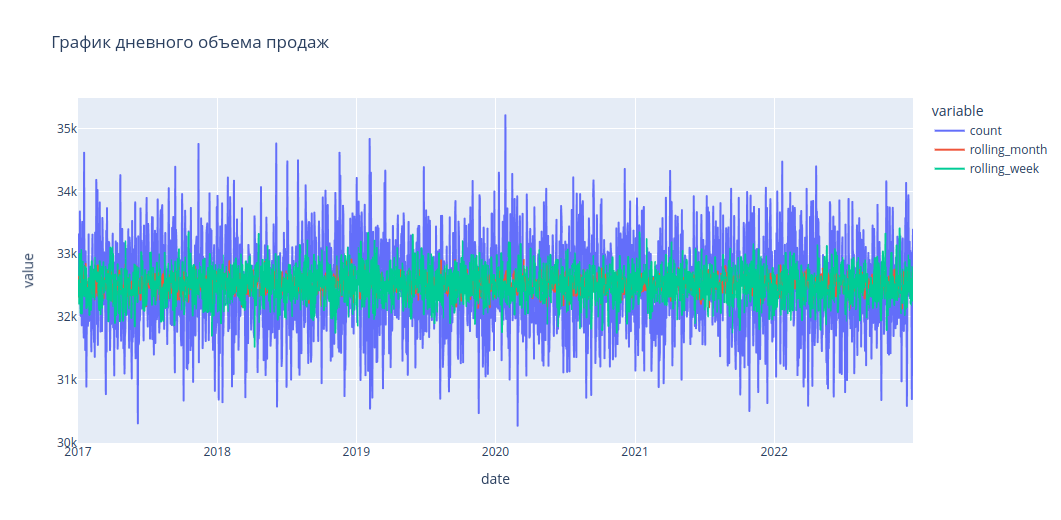

Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить/опровергнуть предположение об однородности.

In [29]:
jb_test(df_c['count'])

<class 'statsmodels.iolib.table.SimpleTable'>

Таким образом, данные имеют некоторое отклонение от нормального распределения, но статистически значимого отличия от него нет. Данные имеют примерно симметричное распределение с более тяжелыми хвостами.

Теперь, для проверки стационарности, давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней.

In [30]:
fuller_test(df_c['count'])

adf:  -25.07963739997774
p-value:  0.0
Critical values:  {'1%': -3.433385280100795, '5%': -2.8628808769203995, '10%': -2.567483816537633}


'Единичных корней нет, ряд стационарен'

* adf статистика равна -25.318172927791085. Это означает, что значения тестовой статистики существенно меньше критических значений на всех уровнях доверия (1%, 5%, 10%)
* P-value равно 0.0. Значение p-value меньше заданного уровня значимости (0.05), что также позволяет нам отвергнуть нулевую гипотезу и подтверждает наличие стационарности в ряде.
* Critical values: {'1%': -3.4333435948613777, '5%': -2.8628624711279094, '10%': -2.5674740166474006}. Поскольку adf статистика (-25.318172927791085) меньше всех критических значений, это подтверждает наличие стационарности в ряде.

### Декомпозиция
Проведем декомпозицию для просмотра тренда и сезонности

In [31]:
df_c = df_c.set_index('date').sort_index().dropna()
df_c.index = pd.to_datetime(df_c.index)

dec_list = [df_c["count"], df_c["rolling_month"], df_c["rolling_week"]]
legend_list = ['count', "rolling_mean", "rolling_week"]

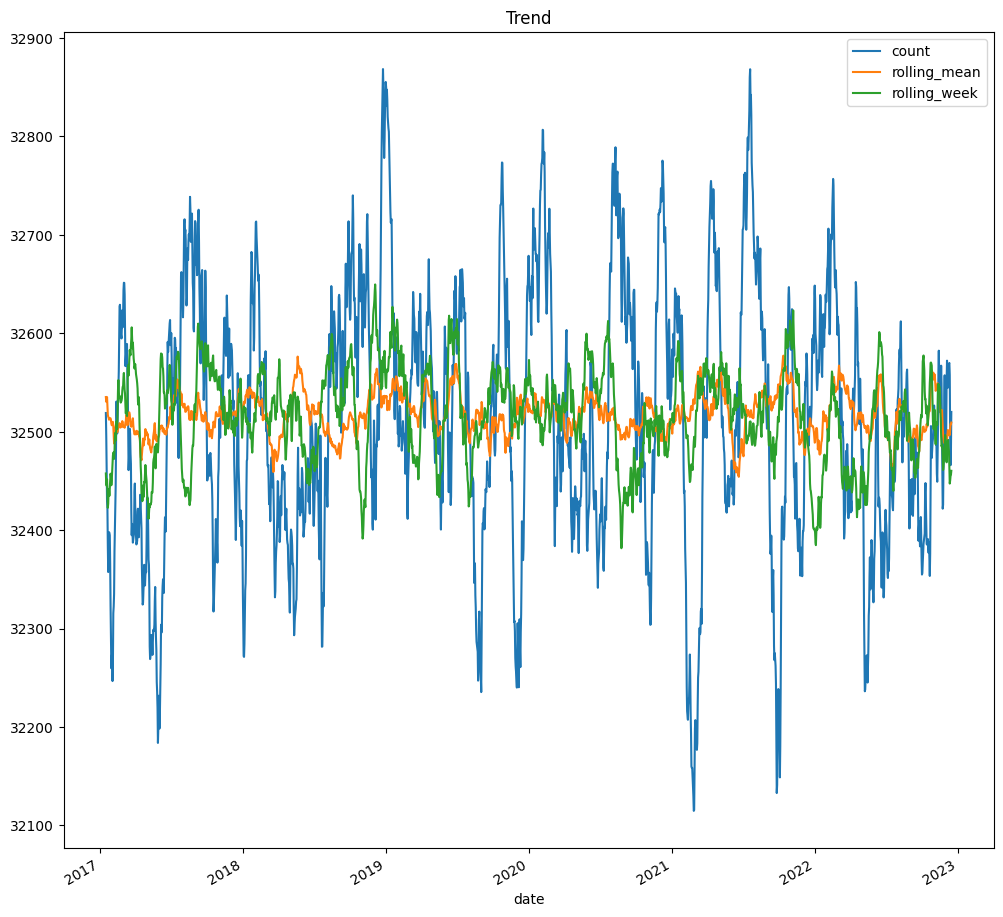

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12))

for el in dec_list:
    decomposed_df = seasonal_decompose(el, model='additive', period=30)
    decomposed_df.trend.plot(title='Trend', ax = axs)
    del decomposed_df
    
plt.legend(legend_list)
plt.show()

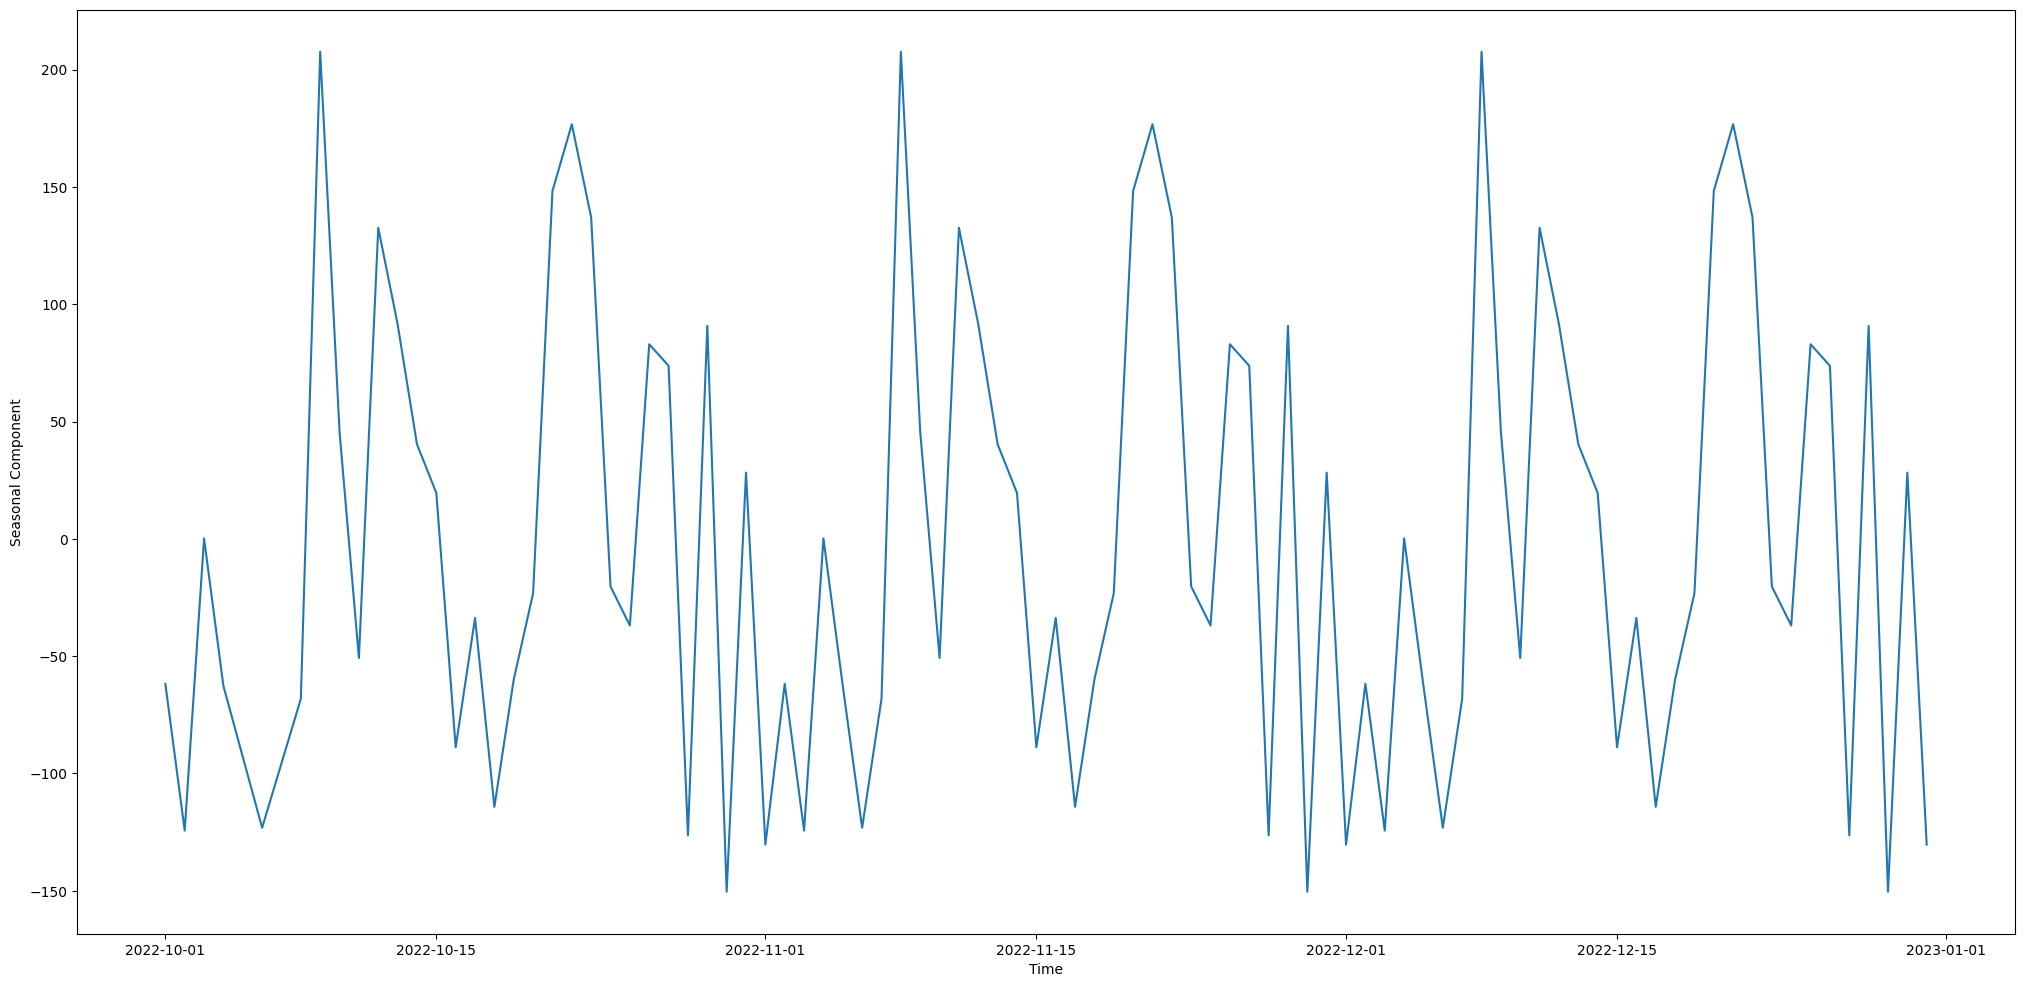

In [33]:
plot_sason_tail(df_c['count'])

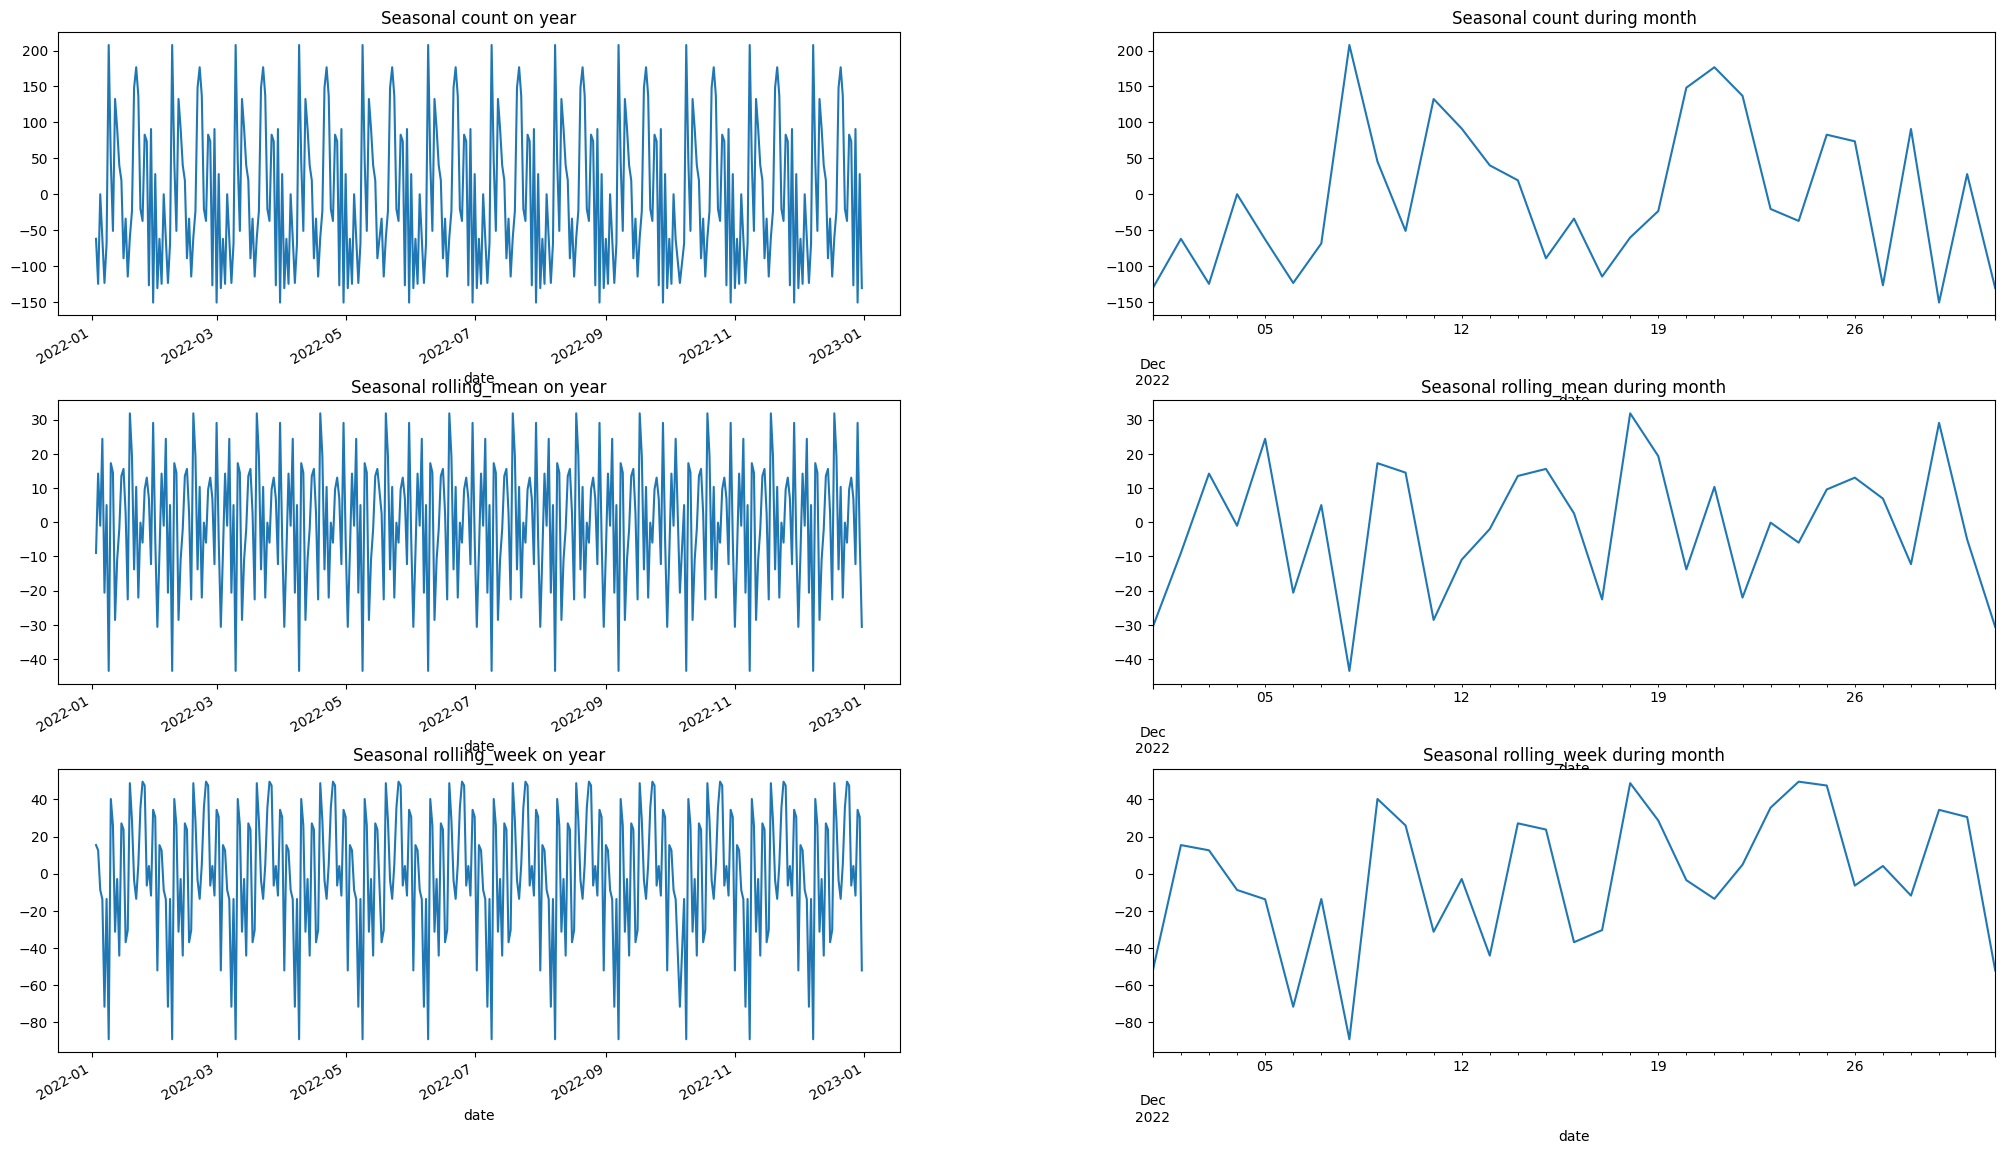

In [34]:
plot_seasonal_dec(dec_list)

## Средняя дневная выручка

In [35]:
df_m["rolling_month"] = df_m["avg_rev"].shift().rolling(30).mean()
df_m["rolling_week"] = df_m["avg_rev"].shift().rolling(7).mean()

df_m= df_m.sort_values('date')

In [36]:
df_m

date       avg_rev  rolling_month  rolling_week
754   2017-01-01  69623.628011   69548.134980  69619.027298
541   2017-01-02  69760.006784   69654.196508  69653.280258
841   2017-01-03  69545.297222   69619.857023  69766.763037
1120  2017-01-04  69648.153222   69773.676175  69612.664927
1293  2017-01-05  69746.778233   69638.944646  69674.967812
...          ...           ...            ...           ...
1749  2022-12-27  69322.684207   69655.585435  69817.899576
730   2022-12-28  69918.638784   69587.084600  69433.359524
1773  2022-12-29  69476.431649   69625.707041  69625.697649
969   2022-12-30  69308.859588   69653.416636  69632.177404
1466  2022-12-31  69339.471938   69602.677781  69556.153253

[2191 rows x 4 columns]

In [37]:
fig = px.line(df_m, x='date', y=['avg_rev', 'rolling_month', 'rolling_week'], title="График средней дневной выручки")

fig.show(renderer='iframe')

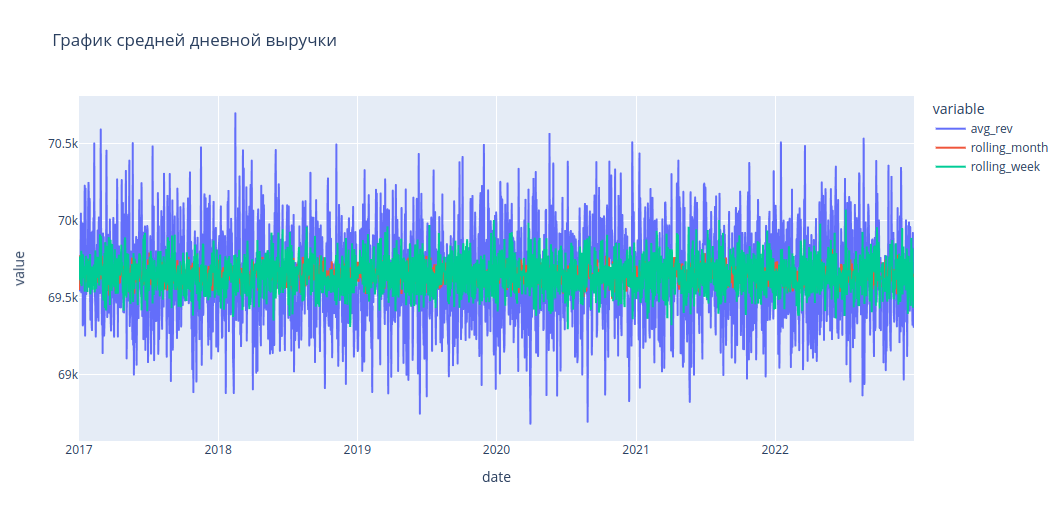

Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить/опровергнуть предположение об однородности.

In [38]:
jb_test(df_m['avg_rev'])

<class 'statsmodels.iolib.table.SimpleTable'>

Таким образом, данные имеют некоторое отклонение от нормального распределения, но статистически значимого отличия от него нет.

Теперь, для проверки стационарности, давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней.

In [39]:
fuller_test(df_m['avg_rev'])

adf:  -46.42966515594549
p-value:  0.0
Critical values:  {'1%': -3.43333948922474, '5%': -2.8628606583021843, '10%': -2.5674730514376263}


'Единичных корней нет, ряд стационарен'

* adf статистика равна -46.42966515594549. Это означает, что значения тестовой статистики существенно меньше критических значений на всех уровнях доверия (1%, 5%, 10%)
* P-value равно 0.0. Значение p-value меньше заданного уровня значимости (0.05), что также позволяет нам отвергнуть нулевую гипотезу и подтверждает наличие стационарности в ряде.
* Critical values: {'1%': -3.43333948922474, '5%': -2.8628606583021843, '10%': -2.5674730514376263}. Поскольку adf статистика (-46.42966515594549) меньше всех критических значений, это подтверждает наличие стационарности в ряде.

## Декомпозиция
Проведем декомпозицию для просмотра тренда и сезонности

In [40]:
df_m = df_m.set_index('date').sort_index().dropna()
df_m.index = pd.to_datetime(df_m.index)

dec_list = [df_m["avg_rev"], df_m["rolling_month"], df_m["rolling_week"]]
legend_list = ['avg_rev', "rolling_mean", "rolling_week"]

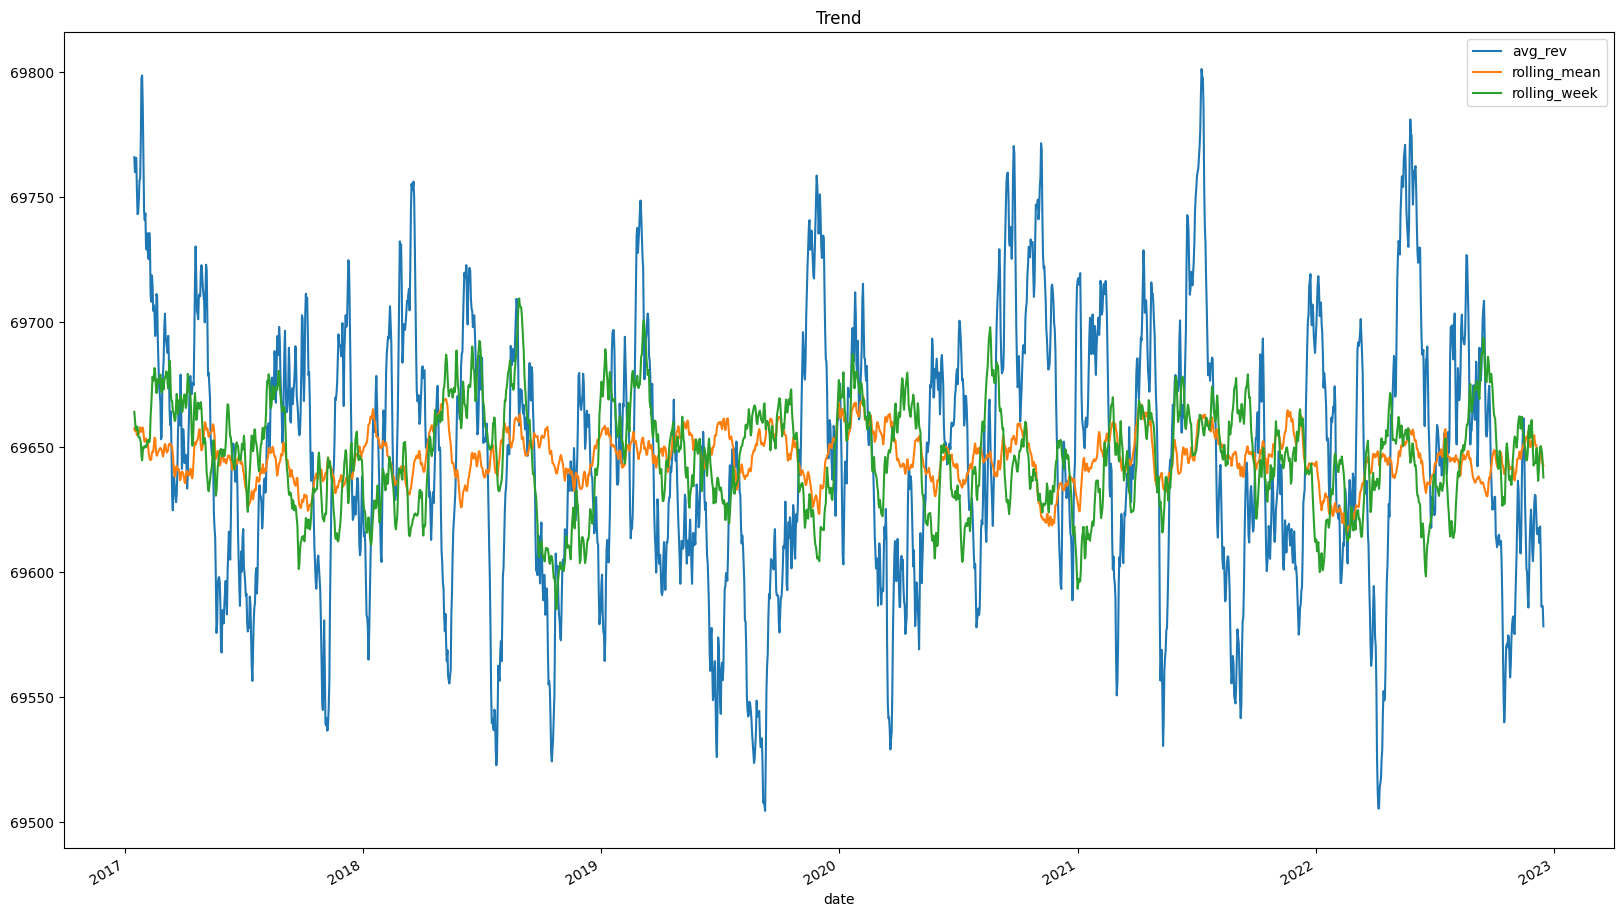

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12))

for el in dec_list:
    decomposed_df = seasonal_decompose(el, model='additive', period=30)
    decomposed_df.trend.plot(title='Trend', ax = axs)
    del decomposed_df
    
plt.legend(legend_list)
plt.show()

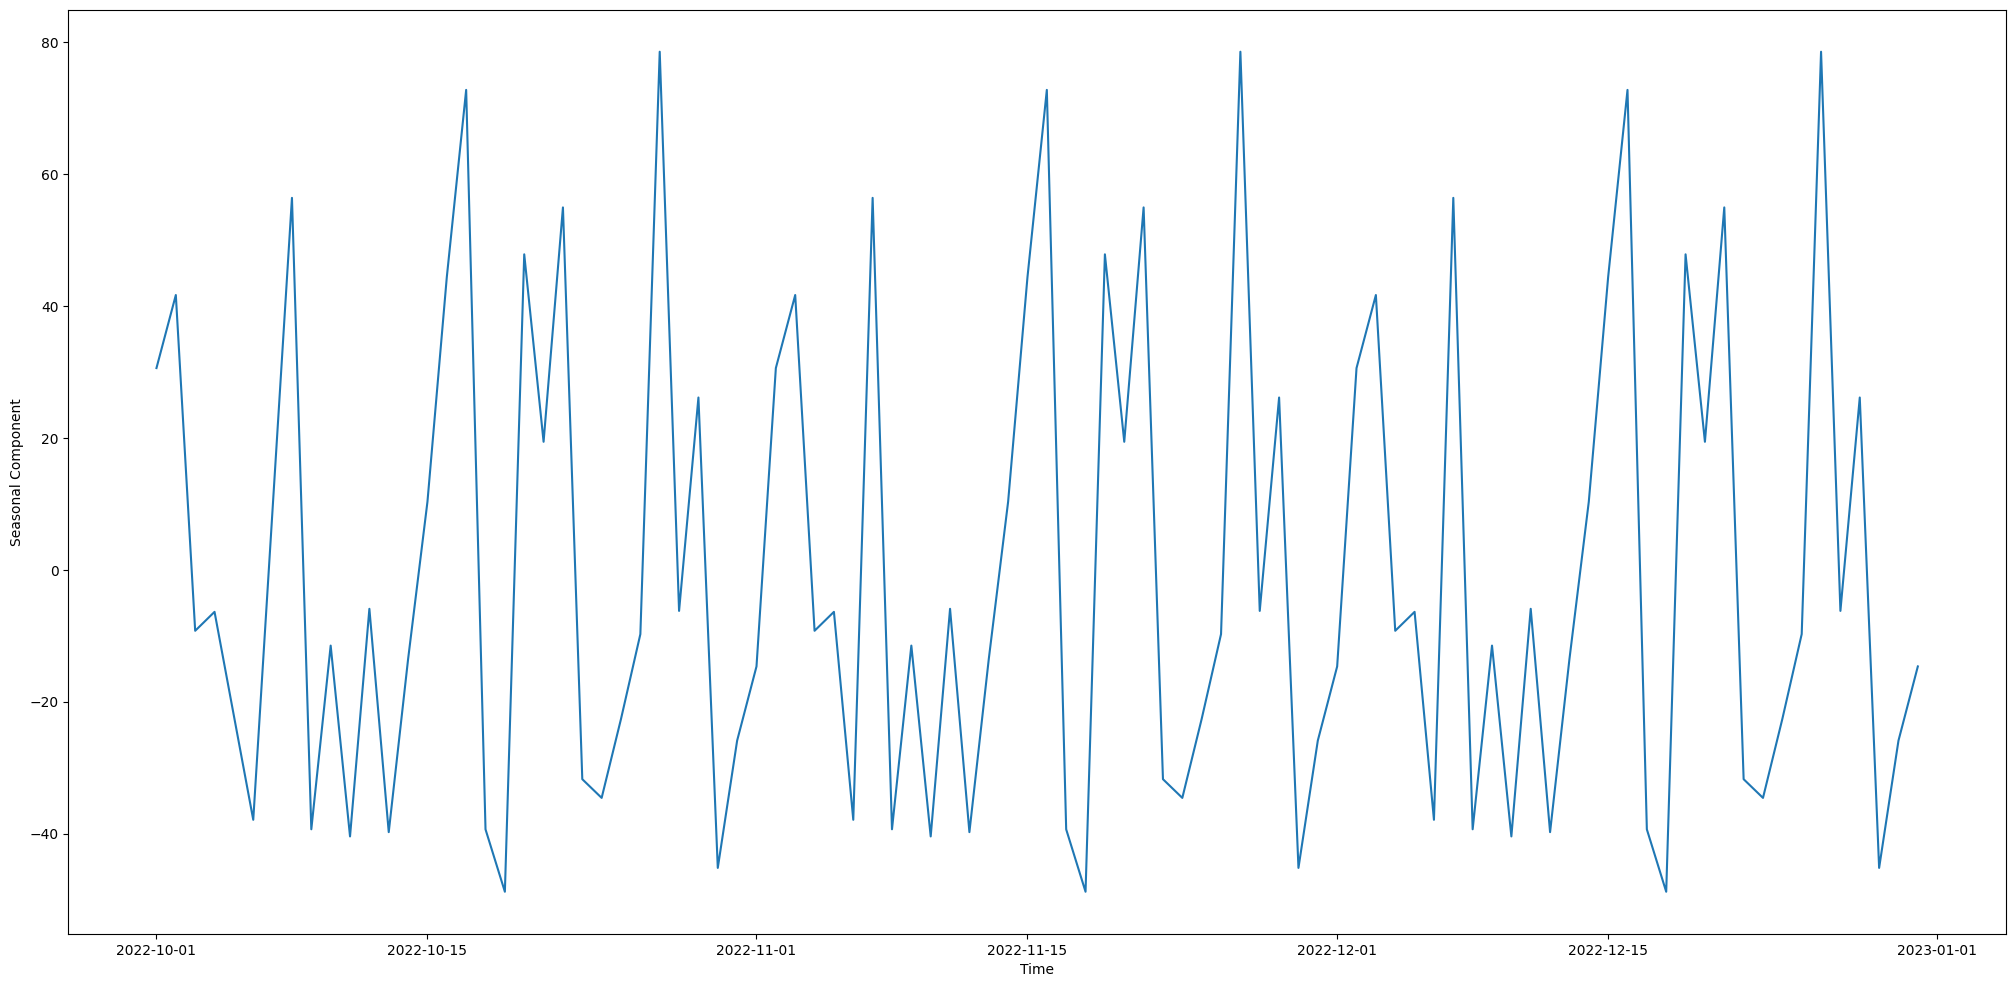

In [42]:
plot_sason_tail(df_m['avg_rev'])

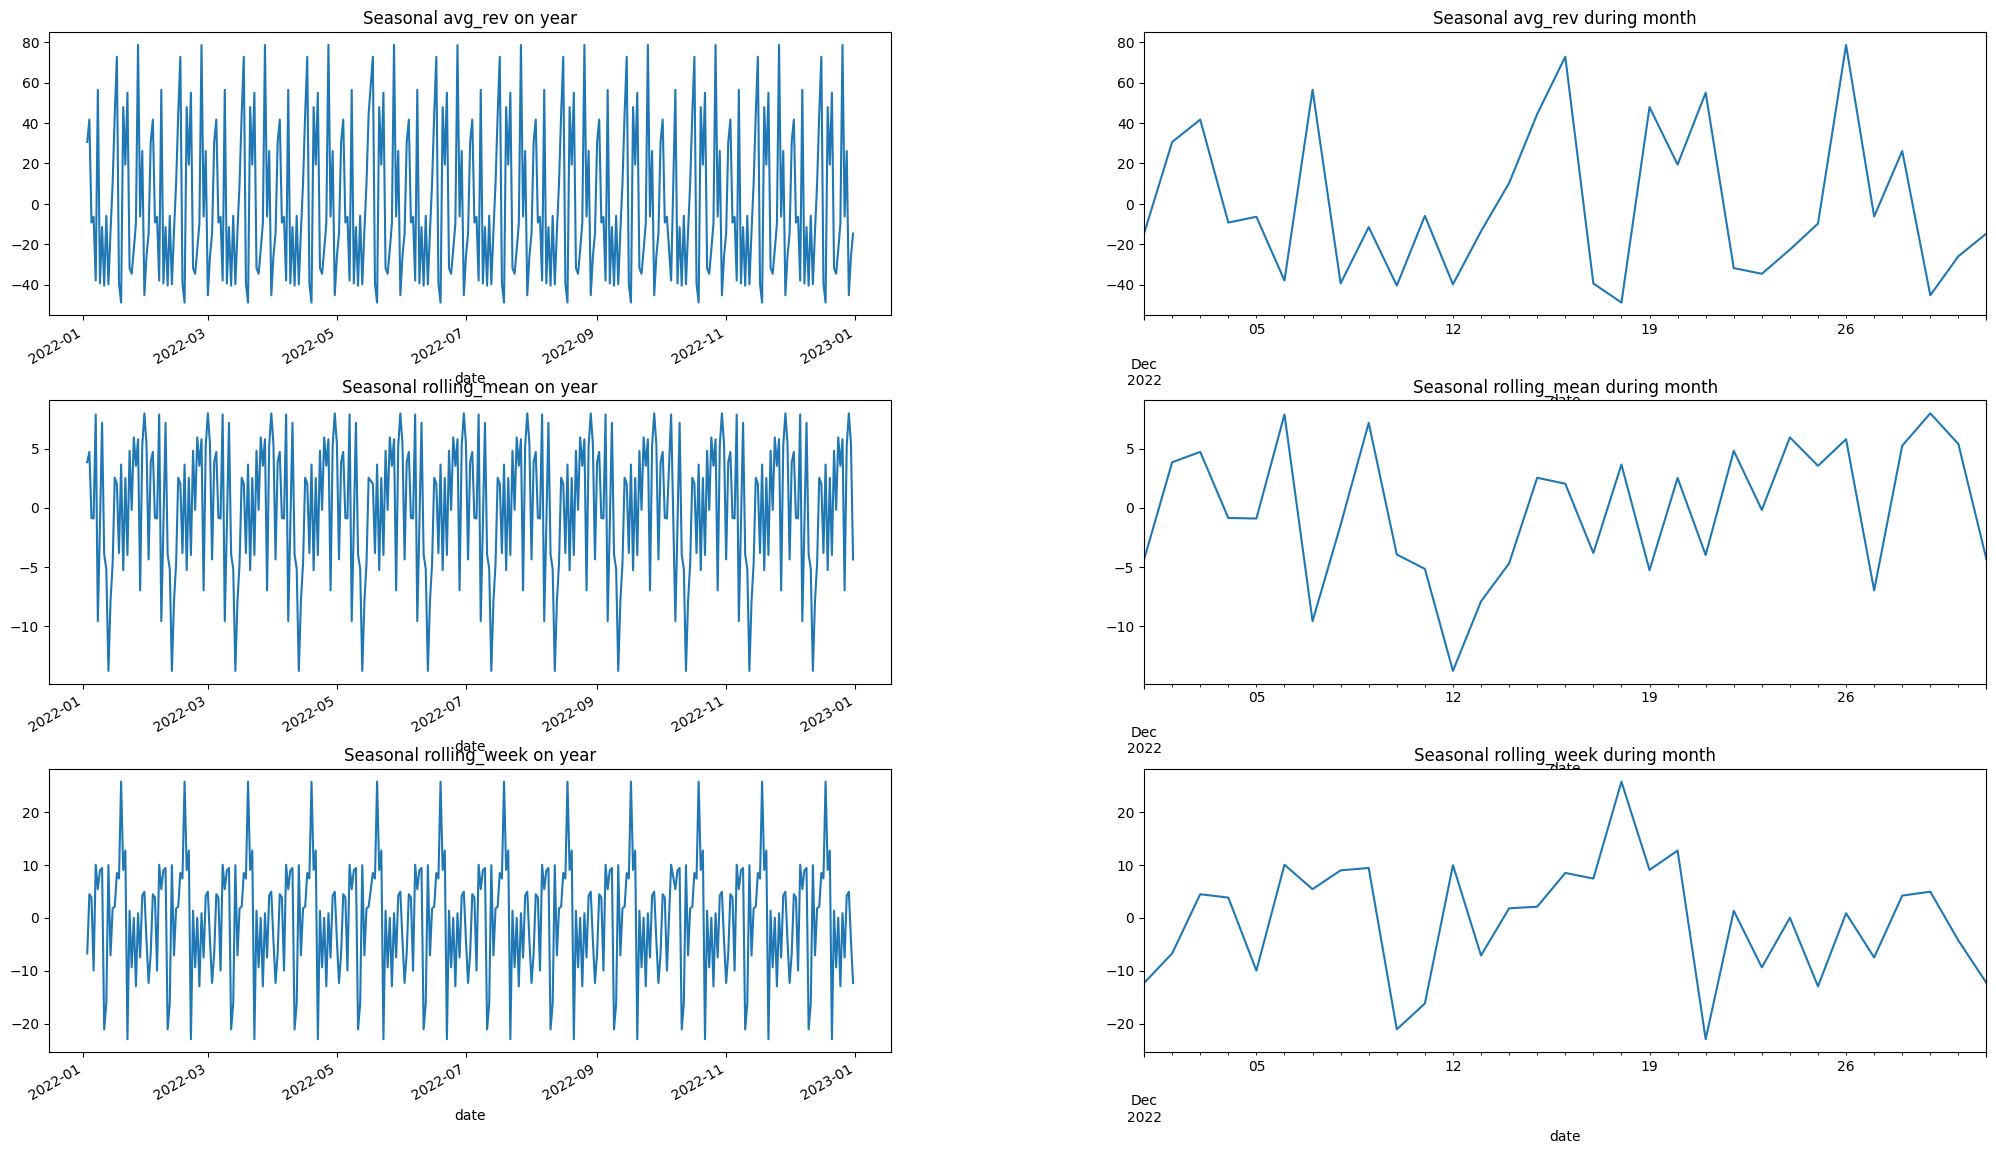

In [43]:
plot_seasonal_dec(dec_list)

# Подготовка данных

## Объем продаж

In [44]:
final_c = df_c
final_c['dayofweek'] = final_c.index.dayofweek

for lag in range(1, 30 + 1):
    final_c[f'lag_{lag}'] = final_c['count'].shift(lag)

final_c.dropna(inplace=True)

In [45]:
final_c

count  rolling_month  rolling_week  dayofweek    lag_1    lag_2  \
date                                                                          
2017-01-31  31952   32401.400000  32031.571429          1  31935.0  33314.0   
2017-02-01  32317   32483.266667  32229.142857          2  31952.0  31935.0   
2017-02-02  31955   32540.333333  32460.142857          3  32317.0  31952.0   
2017-02-03  32346   32608.433333  32798.142857          4  31955.0  32317.0   
2017-02-04  32186   32357.000000  32111.857143          5  32346.0  31955.0   
...           ...            ...           ...        ...      ...      ...   
2022-12-27  32173   32523.300000  32185.714286          1  33016.0  32417.0   
2022-12-28  30689   32709.733333  32792.000000          2  32173.0  33016.0   
2022-12-29  32443   32617.433333  32339.428571          3  30689.0  32173.0   
2022-12-30  32839   32331.866667  32258.142857          4  32443.0  30689.0   
2022-12-31  33390   32496.866667  32457.142857          5  32839.0  32443.0   

              lag_3    lag_4    lag_5    lag_6  ...   lag_21   lag_22  \
date                                            ...                     
2017-01-31  32183.0  31857.0  32437.0  32179.0  ...  32684.0  33246.0   
2017-02-01  33314.0  32183.0  31857.0  32437.0  ...  31864.0  32684.0   
2017-02-02  31935.0  33314.0  32183.0  31857.0  ...  33514.0  31864.0   
2017-02-03  31952.0  31935.0  33314.0  32183.0  ...  32459.0  33514.0   
2017-02-04  32317.0  31952.0  31935.0  33314.0  ...  32832.0  32459.0   
...             ...      ...      ...      ...  ...      ...      ...   
2022-12-27  33051.0  32674.0  33196.0  32334.0  ...  31800.0  31906.0   
2022-12-28  32417.0  33051.0  32674.0  33196.0  ...  31775.0  31800.0   
2022-12-29  33016.0  32417.0  33051.0  32674.0  ...  32364.0  31775.0   
2022-12-30  32173.0  33016.0  32417.0  33051.0  ...  31888.0  32364.0   
2022-12-31  30689.0  32173.0  33016.0  32417.0  ...  32903.0  31888.0   

             lag_23   lag_24   lag_25   lag_26   lag_27   lag_28   lag_29  \
date                                                                        
2017-01-31  32014.0  32199.0  33678.0  32223.0  32777.0  33221.0  33314.0   
2017-02-01  33246.0  32014.0  32199.0  33678.0  32223.0  32777.0  33221.0   
2017-02-02  32684.0  33246.0  32014.0  32199.0  33678.0  32223.0  32777.0   
2017-02-03  31864.0  32684.0  33246.0  32014.0  32199.0  33678.0  32223.0   
2017-02-04  33514.0  31864.0  32684.0  33246.0  32014.0  32199.0  33678.0   
...             ...      ...      ...      ...      ...      ...      ...   
2022-12-27  33248.0  32748.0  32678.0  30972.0  32804.0  31686.0  33282.0   
2022-12-28  31906.0  33248.0  32748.0  32678.0  30972.0  32804.0  31686.0   
2022-12-29  31800.0  31906.0  33248.0  32748.0  32678.0  30972.0  32804.0   
2022-12-30  31775.0  31800.0  31906.0  33248.0  32748.0  32678.0  30972.0   
2022-12-31  32364.0  31775.0  31800.0  31906.0  33248.0  32748.0  32678.0   

             lag_30  
date                 
2017-01-31  32380.0  
2017-02-01  33314.0  
2017-02-02  33221.0  
2017-02-03  32777.0  
2017-02-04  32223.0  
...             ...  
2022-12-27  33242.0  
2022-12-28  33282.0  
2022-12-29  31686.0  
2022-12-30  32804.0  
2022-12-31  30972.0  

[2131 rows x 34 columns]

In [46]:
train_c, test_c = train_test_split(final_c, shuffle=False, test_size=0.1)

features_train_c, target_train_c = train_c.drop(['count'], axis=1), train_c['count']
features_test_c, target_test_c = test_c.drop(['count'], axis=1), test_c['count']

## Средняя дневная выручка

In [47]:
final_m = df_m
final_m['dayofweek'] = final_m.index.dayofweek

for lag in range(1, 30 + 1):
    final_m[f'lag_{lag}'] = final_m['avg_rev'].shift(lag)

final_m.dropna(inplace=True)

In [48]:
final_m

avg_rev  rolling_month  rolling_week  dayofweek  \
date                                                               
2017-01-31  69355.181647   69571.168226  69519.768488          1   
2017-02-01  69670.325030   69576.313020  69561.373781          2   
2017-02-02  69920.256642   69694.890255  69662.813842          3   
2017-02-03  69329.544086   69695.451235  69668.471573          4   
2017-02-04  69287.838905   69620.121418  69701.070041          5   
...                  ...            ...           ...        ...   
2022-12-27  69322.684207   69655.585435  69817.899576          1   
2022-12-28  69918.638784   69587.084600  69433.359524          2   
2022-12-29  69476.431649   69625.707041  69625.697649          3   
2022-12-30  69308.859588   69653.416636  69632.177404          4   
2022-12-31  69339.471938   69602.677781  69556.153253          5   

                   lag_1         lag_2         lag_3         lag_4  \
date                                                                 
2017-01-31  69526.251104  70139.884733  69692.624864  70114.894748   
2017-02-01  69355.181647  69526.251104  70139.884733  69692.624864   
2017-02-02  69670.325030  69355.181647  69526.251104  70139.884733   
2017-02-03  69920.256642  69670.325030  69355.181647  69526.251104   
2017-02-04  69329.544086  69920.256642  69670.325030  69355.181647   
...                  ...           ...           ...           ...   
2022-12-27  69527.411073  69617.830583  69639.138461  69474.132123   
2022-12-28  69322.684207  69527.411073  69617.830583  69639.138461   
2022-12-29  69918.638784  69322.684207  69527.411073  69617.830583   
2022-12-30  69476.431649  69918.638784  69322.684207  69527.411073   
2022-12-31  69308.859588  69476.431649  69918.638784  69322.684207   

                   lag_5         lag_6  ...        lag_21        lag_22  \
date                                    ...                               
2017-01-31  70244.388939  70072.460735  ...  69980.981734  69760.144232   
2017-02-01  70114.894748  70244.388939  ...  69318.269772  69980.981734   
2017-02-02  69692.624864  70114.894748  ...  69331.342066  69318.269772   
2017-02-03  70139.884733  69692.624864  ...  69723.327552  69331.342066   
2017-02-04  69526.251104  70139.884733  ...  69978.080838  69723.327552   
...                  ...           ...  ...           ...           ...   
2022-12-27  69615.761146  69957.322818  ...  69647.404686  69432.645416   
2022-12-28  69474.132123  69615.761146  ...  69342.884626  69647.404686   
2022-12-29  69639.138461  69474.132123  ...  69657.299190  69342.884626   
2022-12-30  69617.830583  69639.138461  ...  69733.523708  69657.299190   
2022-12-31  69527.411073  69617.830583  ...  70000.325715  69733.523708   

                  lag_23        lag_24        lag_25        lag_26  \
date                                                                 
2017-01-31  69647.260480  69532.936081  70044.436839  69746.778233   
2017-02-01  69760.144232  69647.260480  69532.936081  70044.436839   
2017-02-02  69980.981734  69760.144232  69647.260480  69532.936081   
2017-02-03  69318.269772  69980.981734  69760.144232  69647.260480   
2017-02-04  69331.342066  69318.269772  69980.981734  69760.144232   
...                  ...           ...           ...           ...   
2022-12-27  68966.463998  69610.544325  69311.196462  69644.297472   
2022-12-28  69432.645416  68966.463998  69610.544325  69311.196462   
2022-12-29  69647.404686  69432.645416  68966.463998  69610.544325   
2022-12-30  69342.884626  69647.404686  69432.645416  68966.463998   
2022-12-31  69657.299190  69342.884626  69647.404686  69432.645416   

                  lag_27        lag_28        lag_29        lag_30  
date                                                                
2017-01-31  69648.153222  69545.297222  69760.006784  69623.628011  
2017-02-01  69746.778233  69648.153222  69545.297222  69760.006784  
2017-02-02  70044.436839  69746.778233  69648.153222  6954

In [49]:
train_m, test_m = train_test_split(final_m, shuffle=False, test_size=0.1)

features_train_m, target_train_m = train_m.drop(['avg_rev'], axis=1), train_m['avg_rev']
features_test_m, target_test_m = test_m.drop(['avg_rev'], axis=1), test_m['avg_rev']

### Вывод
* Признаки созданы
* Подготовка к обучению завершена.


# Обучение
## Объем продаж

In [50]:
def default_model_rmse(model, features_train, features_test, target_train, target_test, title):
    """ RMSE на моделях из коробки, отдает кортеж с rmse на обучающей и тестовой выборках """
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    
    print(f'---- {title} ----')
    print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred)**0.5)
    print("RMSE тестовой выборки: ", mean_squared_error(target_test, test_pred)**0.5)
    print("MAPE обучающей выборки:", mean_absolute_percentage_error(target_train, train_pred))
    print("MAPE тестовой выборки: ", mean_absolute_percentage_error(target_test, test_pred),'\n')

    plt.plot(list(target_test), label='test')
    plt.plot(test_pred, label='pred')
    plt.legend()
    plt.show()

    return (mean_squared_error(target_train, train_pred)**0.5, mean_squared_error(target_test, test_pred)**0.5,
            mean_absolute_percentage_error(target_train, train_pred), mean_absolute_percentage_error(target_test, test_pred))

---- LinearRegression ----
RMSE обучающей выборки: 732.372880611798
RMSE тестовой выборки:  706.1422798015836
MAPE обучающей выборки: 0.01824124045432464
MAPE тестовой выборки:  0.017363694267940856 



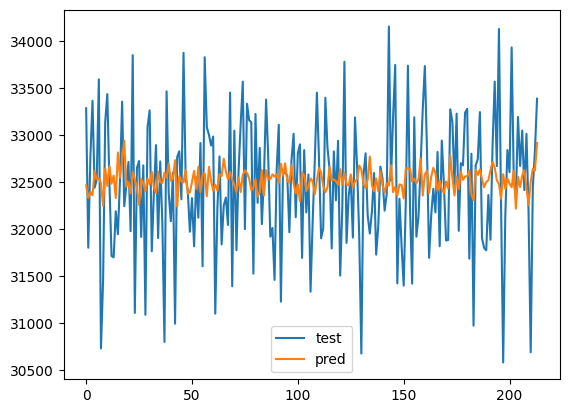

CPU times: user 530 ms, sys: 863 ms, total: 1.39 s
Wall time: 254 ms


(732.372880611798,
 706.1422798015836,
 0.01824124045432464,
 0.017363694267940856)

In [51]:
%%time

default_LR = default_model_rmse(LinearRegression(),
                                features_train_c,
                                features_test_c,
                                target_train_c,
                                target_test_c,
                                'LinearRegression')
default_LR

---- RandomForestRegressor ----
RMSE обучающей выборки: 280.3804407422325
RMSE тестовой выборки:  721.0908816709388
MAPE обучающей выборки: 0.006905658637388957
MAPE тестовой выборки:  0.017756762127375404 



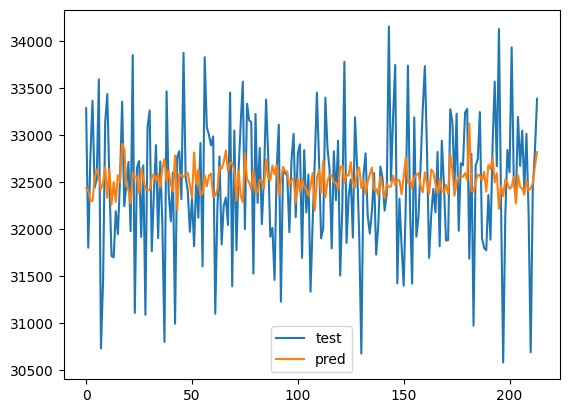

CPU times: user 6.47 s, sys: 159 ms, total: 6.63 s
Wall time: 6.36 s


(280.3804407422325,
 721.0908816709388,
 0.006905658637388957,
 0.017756762127375404)

In [52]:
%%time

default_RFR = default_model_rmse(RandomForestRegressor(random_state=RND),
                                 features_train_c,
                                 features_test_c,
                                 target_train_c,
                                 target_test_c,
                                 'RandomForestRegressor')
default_RFR

---- XGBRegressor ----
RMSE обучающей выборки: 44.40629515660053
RMSE тестовой выборки:  802.202969471906
MAPE обучающей выборки: 0.000967754130393193
MAPE тестовой выборки:  0.01966789445138726 



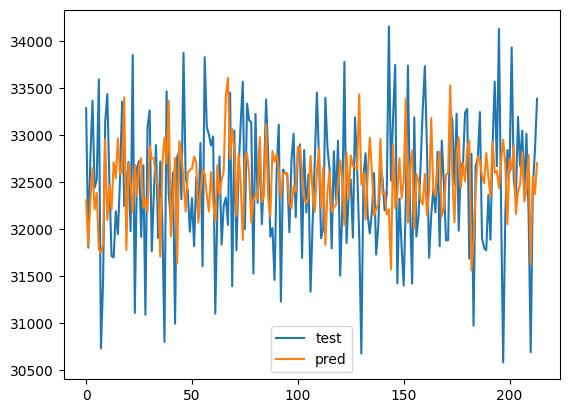

CPU times: user 3.47 s, sys: 101 ms, total: 3.58 s
Wall time: 543 ms


(44.40629515660053,
 802.202969471906,
 0.000967754130393193,
 0.01966789445138726)

In [53]:
%%time

default_XGB = default_model_rmse(XGBRegressor(random_state=RND),
                                features_train_c,
                                features_test_c,
                                target_train_c,
                                target_test_c,
                                'XGBRegressor')
default_XGB

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8167
[LightGBM] [Info] Number of data points in the train set: 1917, number of used features: 33
[LightGBM] [Info] Start training from score 32519.514345
---- LGBMRegressor ----
RMSE обучающей выборки: 243.28413609543517
RMSE тестовой выборки:  775.5102917464814
MAPE обучающей выборки: 0.0059063019291633
MAPE тестовой выборки:  0.018822029264964922 



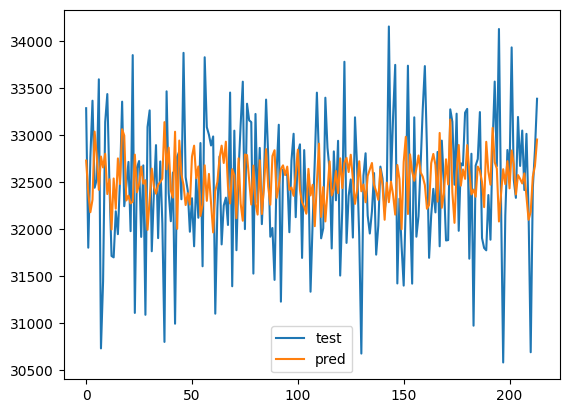

CPU times: user 946 ms, sys: 205 ms, total: 1.15 s
Wall time: 321 ms


(243.28413609543517,
 775.5102917464814,
 0.0059063019291633,
 0.018822029264964922)

In [54]:
%%time

default_LGBMR = default_model_rmse(LGBMRegressor(random_state=RND),
                                   features_train_c,
                                   features_test_c,
                                   target_train_c,
                                   target_test_c,
                                   'LGBMRegressor')
default_LGBMR

---- CatBoostRegressor ----
RMSE обучающей выборки: 205.76015283338683
RMSE тестовой выборки:  768.2476975401455
MAPE обучающей выборки: 0.004940115351907652
MAPE тестовой выборки:  0.018994552644929528 



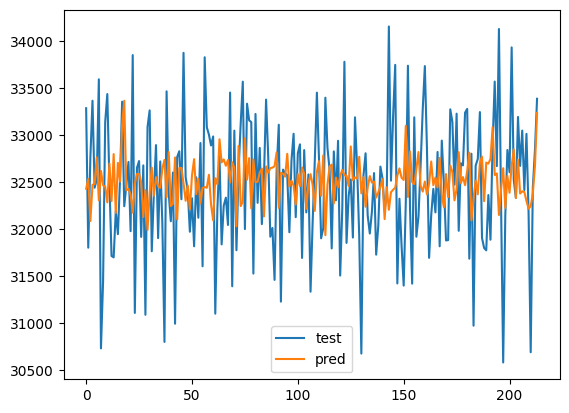

CPU times: user 22 s, sys: 1.87 s, total: 23.9 s
Wall time: 3.32 s


(205.76015283338683,
 768.2476975401455,
 0.004940115351907652,
 0.018994552644929528)

In [55]:
%%time

default_CB = default_model_rmse(CatBoostRegressor(random_state=RND, verbose=0),
                                features_train_c,
                                features_test_c,
                                target_train_c,
                                target_test_c,
                                'CatBoostRegressor')
default_CB

In [56]:
report = pd.DataFrame(columns = ["LinearRegression", "RandomForest", 'XGBRegressor', "LightGBM", "CatBoost"],
                      index = ["RMSE(train)",
                               "RMSE(test)",
                               'MAPE(train)',
                               'MAPE(test)',
                               "Общее время",])


report.iloc[0] = [default_LR[0], default_RFR[0], default_XGB[0], default_LGBMR[0], default_CB[0]]
report.iloc[1] = [default_LR[1], default_RFR[1], default_XGB[1], default_LGBMR[1], default_CB[1]]
report.iloc[2] = [default_LR[2], default_RFR[2], default_XGB[2], default_LGBMR[2], default_CB[2]]
report.iloc[3] = [default_LR[3], default_RFR[3], default_XGB[3], default_LGBMR[3], default_CB[3]]
report.iloc[4] = ['311 мс.', '6.1 с.', '660мс', '322 мс.', '3.57 с.']

display(report)

LinearRegression RandomForest XGBRegressor    LightGBM    CatBoost
RMSE(train)       732.372881   280.380441    44.406295  243.284136  205.760153
RMSE(test)         706.14228   721.090882   802.202969  775.510292  768.247698
MAPE(train)         0.018241     0.006906     0.000968    0.005906     0.00494
MAPE(test)          0.017364     0.017757     0.019668    0.018822    0.018995
Общее время          311 мс.       6.1 с.        660мс     322 мс.     3.57 с.

Исходя из результатов моделей, можно сделать следующие общие выводы:

1. Модель **XGBRegressor** показывает наилучшие результаты для среднеквадратичной ошибки на обучающем наборе данных (RMSE(train)) и абсолютной процентной ошибки на обучающем наборе данных (MAPE(train)). Это указывает на хорошую способность модели **XGBRegressor** адаптироваться к обучающим данным и точно предсказывать значения.

2. Модель **LinearRegression** показывает наилучший результат для среднеквадратичной ошибки на тестовом наборе данных (RMSE(test)), что может означать, что она лучше всего обобщает тренды в данных и наименее подвержена переобучению.

3. Все модели демонстрируют сравнимые результаты для среднеквадратичной ошибки на тестовом наборе данных (RMSE(test)) и абсолютной процентной ошибки на тестовом наборе данных (MAPE(test)). Это может указывать на то, что все модели имеют примерно одинаковую способность предсказывать значения на новых данных.

4. Время выполнения различается для каждой модели, где модели **LinearRegression** и **LightGBM** демонстрируют наименьшее время выполнения, в то время как модель **RandomForest** требует наибольшего времени.

Итак, выбор лучшей модели зависит от конкретных целей и требований проекта. Если важна точность на новых данных, то модель **LinearRegression** может быть предпочтительной. При этом стоит учитывать и время выполнения каждой модели, особенно если необходимо быстро получить предсказания.

Окончательное решение должно быть принято на основе компромисса между точностью, интерпретируемостью модели, быстродействием и другими факторами в целях достижения наилучших результатов для конкретного проекта.

### ARIMA

In [57]:
import warnings

In [58]:
p = d = q = range(0,3)

pdq=list(itertools.product(p, d, q))

In [59]:
for ord in pdq:
    try:
        model = sm.tsa.arima.ARIMA(train_c['count'].values,
                                       order=ord)
        modelfit = model.fit()
        print(f'ARIMA{ord}. AIC: {modelfit.aic}' )
    except:
        continue

ARIMA(0, 0, 0). AIC: 30784.76537559433
ARIMA(0, 0, 1). AIC: 30786.596860444788
ARIMA(0, 0, 2). AIC: 30788.45647420363
ARIMA(0, 1, 0). AIC: 32077.55526900054
ARIMA(0, 1, 1). AIC: 30972.97710395674
ARIMA(0, 1, 2). AIC: 30962.76695760902
ARIMA(0, 2, 0). AIC: 34153.49875794019
ARIMA(0, 2, 1). AIC: 32200.138871335403
ARIMA(0, 2, 2). AIC: 31276.754452907917
ARIMA(1, 0, 0). AIC: 30786.59781869928
ARIMA(1, 0, 1). AIC: 30788.296064360256
ARIMA(1, 0, 2). AIC: 30788.78753130496
ARIMA(1, 1, 0). AIC: 31617.770232282037
ARIMA(1, 1, 1). AIC: 30962.70954793731
ARIMA(1, 1, 2). AIC: 30964.705509300846
ARIMA(1, 2, 0). AIC: 33151.82908903195
ARIMA(1, 2, 1). AIC: 31858.085403014607
ARIMA(1, 2, 2). AIC: 31254.13450711754
ARIMA(2, 0, 0). AIC: 30788.45273562291
ARIMA(2, 0, 1). AIC: 30788.670559182312
ARIMA(2, 0, 2). AIC: 30786.330527309707
ARIMA(2, 1, 0). AIC: 31439.122853181252
ARIMA(2, 1, 1). AIC: 30964.70398453214
ARIMA(2, 1, 2). AIC: 30966.579724732677
ARIMA(2, 2, 0). AIC: 32653.087783199302
ARIMA(2, 2, 1

In [60]:
mymodel = sm.tsa.arima.ARIMA(train_c['count'].values, order =(0, 0, 0)) 
modelfit = mymodel.fit() 
print(modelfit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1917
Model:                          ARIMA   Log Likelihood              -15390.383
Date:                Mon, 11 Dec 2023   AIC                          30784.765
Time:                        16:33:45   BIC                          30795.882
Sample:                             0   HQIC                         30788.856
                               - 1917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.252e+04     16.929   1920.906      0.000    3.25e+04    3.26e+04
sigma2        5.5e+05   1.85e+04     29.729      0.000    5.14e+05    5.86e+05
Ljung-Box (L1) (Q):                   0.17   Jarque-

Исходя из summary модели ARIMA, можно сделать следующие выводы:

1. Оценка коэффициента константы (const) составляет около 32,520. Это означает, что среднее значение переменной y составляет примерно 32,520.

2. Оценка дисперсии ошибок модели (sigma2) равна примерно 550,000. Это значение представляет собой оценку изменчивости ошибок внутри модели. Чем меньше значение sigma2, тем лучше модель соответствует данным и меньше остаточная изменчивость в модели.

3. Тест Ljung-Box (Q) на автокорреляцию первого порядка показывает значение 0.17 с вероятностью 0.68. Значение Q указывает на то, что автокорреляция первого порядка в остатках модели статистически незначима. Вероятность 0.68 указывает на то, что разница в тесте не является статистически значимой.

4. Тест Jarque-Bera (JB) на нормальность остатков показывает значение 2.13 с вероятностью 0.35. Значение JB указывает на то, что остатки модели не являются строго нормально распределенными. Однако, вероятность 0.35 не достигает статистической значимости.

5. Тест на гетероскедастичность (H) показывает значение 0.99 с вероятностью 0.92. Значение H указывает на отсутствие гетероскедастичности (неоднородности дисперсии) в остатках модели. Вероятность 0.92 указывает на то, что разница не является статистически значимой.

6. Значение skew равно 0.02, что указывает на незначительную асимметрию в распределении остатков модели. Это означает, что распределение остатков близко к нормальному распределению.

7. Значение kurtosis равно 2.84, что говорит о нормальности распределения остатков модели. Это указывает на то, что значения остатков не значительно отклоняются от ожидаемой плоскости.

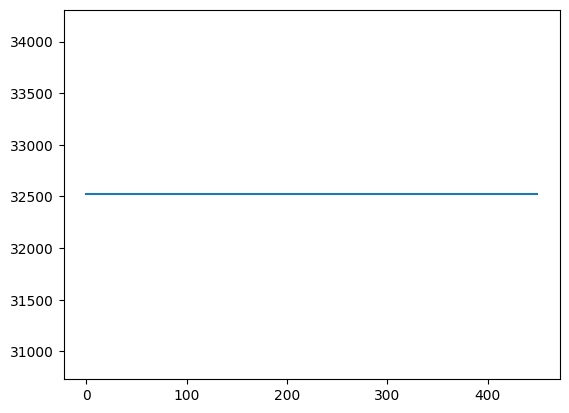

In [61]:
plt.plot(modelfit.forecast(steps=450))
plt.show()

### auto_arima

In [62]:
import pmdarima as pm
from pmdarima import model_selection

arima_model = pm.auto_arima(
    train_c['count'].values,
    max_p=5, max_q=5, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='oscb',
    trace=True,
    error_action='ignore',
    stepwise=False,
    n_fits=5000,
    information_criterion='aic',
    out_of_sample_size=7
)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=30784.766, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=30786.595, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=30788.455, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=30789.433, Time=0.42 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=30786.940, Time=1.00 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=30788.763, Time=1.41 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=30786.600, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=30788.592, Time=0.44 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=30790.513, Time=0.68 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=30791.517, Time=0.83 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=30789.070, Time=1.55 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=30788.454, Time=0.38 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=30790.473, Time=0.64 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=30792.456, Time=1.33 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=30793.345, Time=1.33

In [63]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1917
Model:                        SARIMAX   Log Likelihood              -15390.383
Date:                Mon, 11 Dec 2023   AIC                          30784.766
Time:                        16:34:01   BIC                          30795.883
Sample:                             0   HQIC                         30788.856
                               - 1917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.252e+04     16.932   1920.614      0.000    3.25e+04    3.26e+04
sigma2      5.501e+05   1.85e+04     29.725      0.000    5.14e+05    5.86e+05
Ljung-Box (L1) (Q):                   0.17   Jarque-

In [64]:
y_pred, pred_ci = arima_model.predict(
    n_periods=214,
    alpha=0.05,
    return_conf_int=True
)

In [65]:
df_forecast = pd.DataFrame(
    {'y_pred': y_pred,
    'ci_lower': pred_ci[:,0],
    'ci_upper': pred_ci[:,1]}
)

df_forecast.index = target_test_c.index

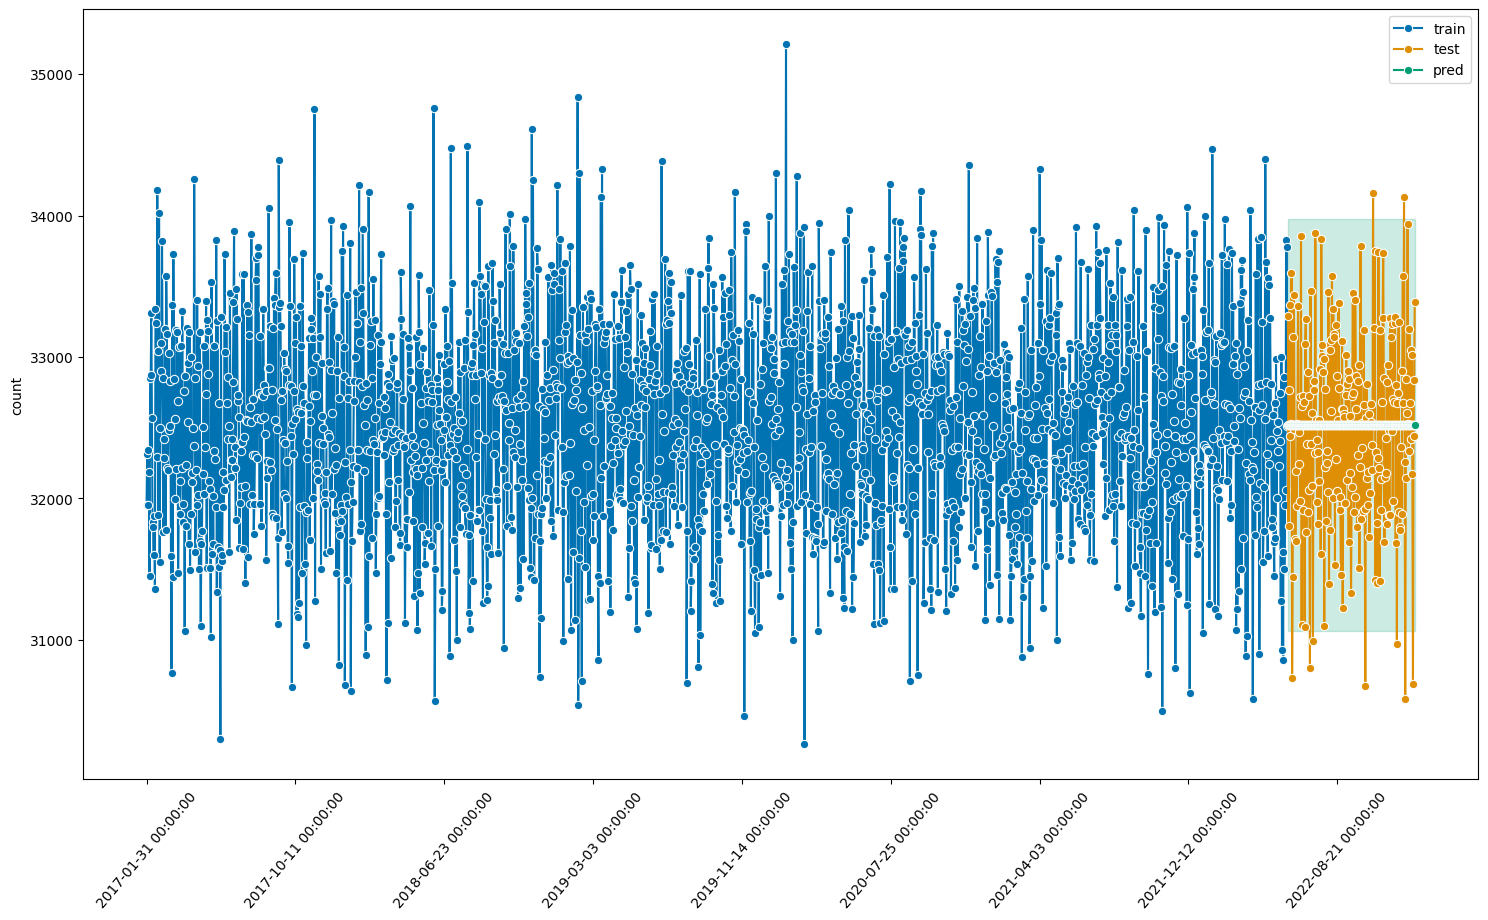

In [66]:
fig, ax = plot_series(target_train_c, target_test_c, df_forecast.y_pred, labels=['train', 'test', 'pred'])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast['ci_lower'],
    df_forecast['ci_upper'],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f'95% pred intervals'
)

fig.set_size_inches(18, 10)
ax.tick_params(axis='x', labelrotation=50)

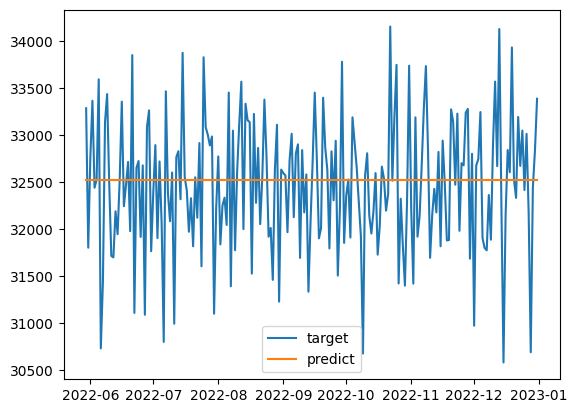

In [67]:
plt.plot(target_test_c, label='target')
plt.plot(df_forecast['y_pred'], label='predict')
plt.legend()
plt.show()

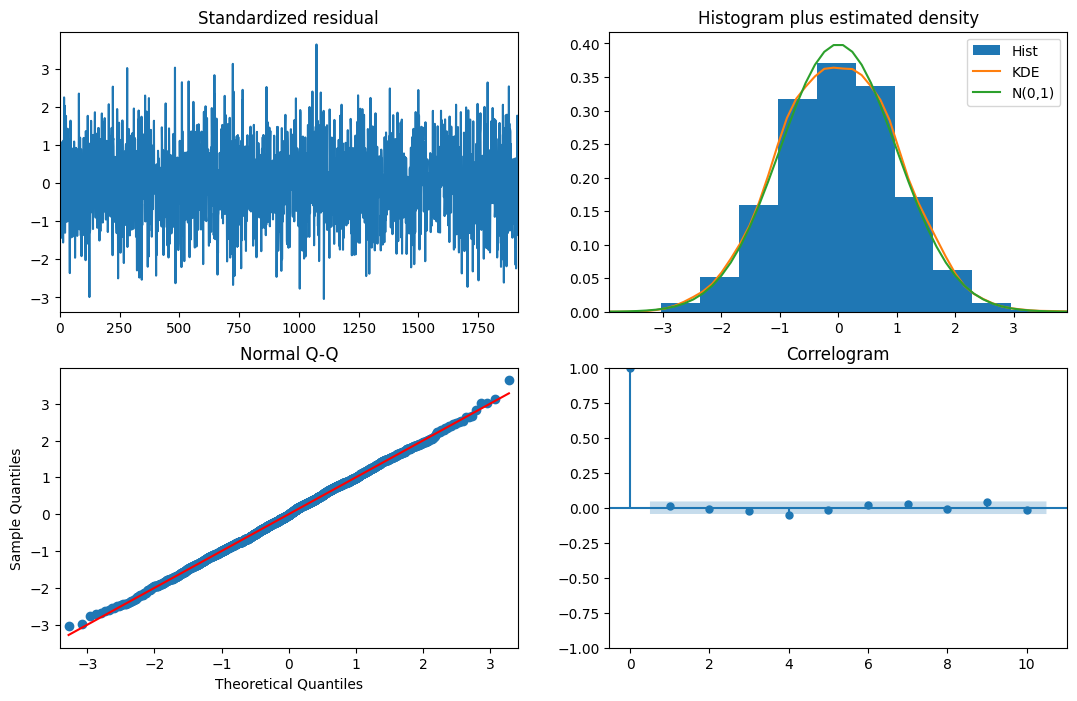

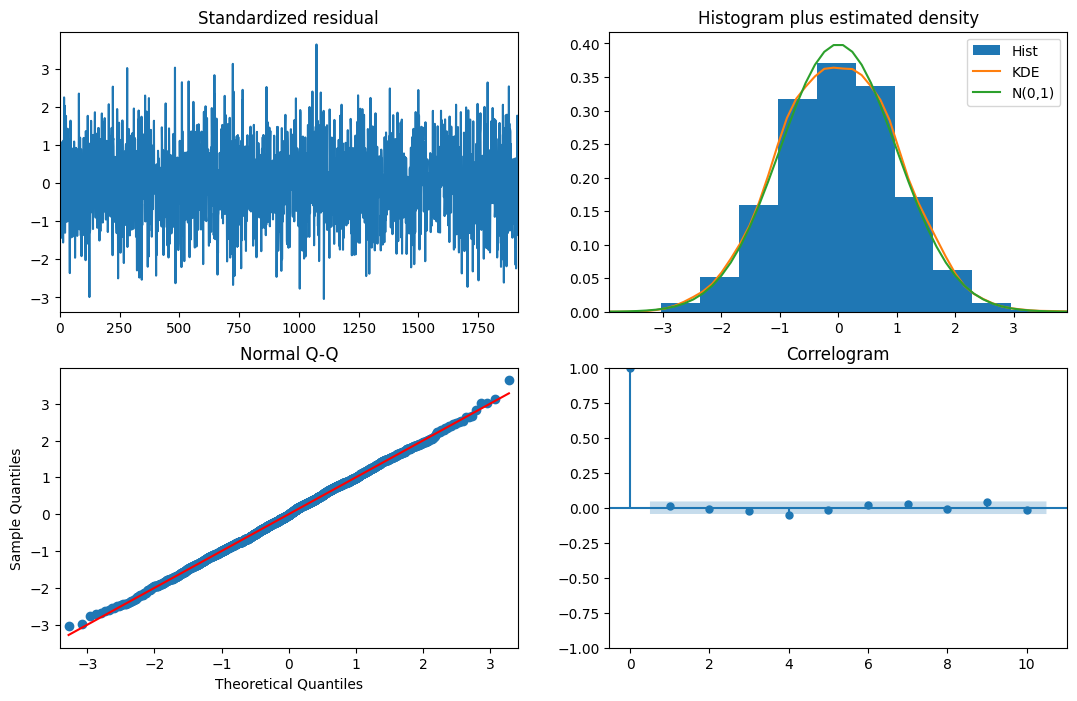

In [68]:
arima_model.plot_diagnostics(figsize=(13,8))

Исходя из summary наилучшей модели auto_arima, можно сделать следующие выводы:

1. Оценка коэффициента константы (intercept) составляет около 32,520. Это означает, что среднее значение переменной y составляет примерно 32,520.

2. Оценка дисперсии ошибок модели (sigma2) составляет примерно 550,000. Это значение указывает на изменчивость ошибок модели. Чем меньше значение sigma2, тем лучше модель соответствует данным, поскольку остаточная изменчивость невелика.

3. Тест Ljung-Box (Q) на автокорреляцию первого порядка показывает значение 0.17 с вероятностью 0.68. Значение Q и вероятность 0.68 указывают на отсутствие статистически значимой автокорреляции первого порядка в остатках модели.

4. Тест Jarque-Bera (JB) на нормальность остатков показывает значение 2.13 с вероятностью 0.35. Значение JB и вероятность 0.35 указывают на ненормальность распределения остатков, но это отклонение не является статистически значимым.

5. Тест на гетероскедастичность (H) показывает значение 0.99 с вероятностью 0.92. Значение H и вероятность 0.92 указывают на отсутствие гетероскедастичности (неоднородности дисперсии) в остатках модели.

6. Значение skew (асимметрии) равно 0.02, что указывает на незначительную положительную асимметрию в распределении остатков модели. То есть, распределение остатков немного смещено вправо относительно нормального распределения.

7. Значение kurtosis (эксцесса) равно 2.84, что указывает на нормальность распределения остатков. Значение эксцесса близко к ожидаемому для нормального распределения, что подтверждает, что остатки модели имеют форму, близкую к нормальному распределению

## Средняя дневная выручка

---- LinearRegression ----
RMSE обучающей выборки: 312.0665310074383
RMSE тестовой выборки:  310.32820005051985
MAPE обучающей выборки: 0.003606531989087748
MAPE тестовой выборки:  0.003551359713036821 



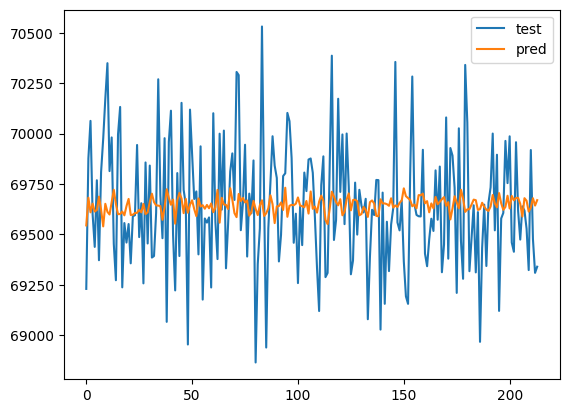

CPU times: user 549 ms, sys: 536 ms, total: 1.09 s
Wall time: 262 ms


(312.0665310074383,
 310.32820005051985,
 0.003606531989087748,
 0.003551359713036821)

In [69]:
%%time

default_LR = default_model_rmse(LinearRegression(),
                                features_train_m,
                                features_test_m,
                                target_train_m,
                                target_test_m,
                                'LinearRegression')
default_LR

---- RandomForestRegressor ----
RMSE обучающей выборки: 120.57775182989452
RMSE тестовой выборки:  309.54443219260196
MAPE обучающей выборки: 0.0013815959186788604
MAPE тестовой выборки:  0.0035239820528541023 



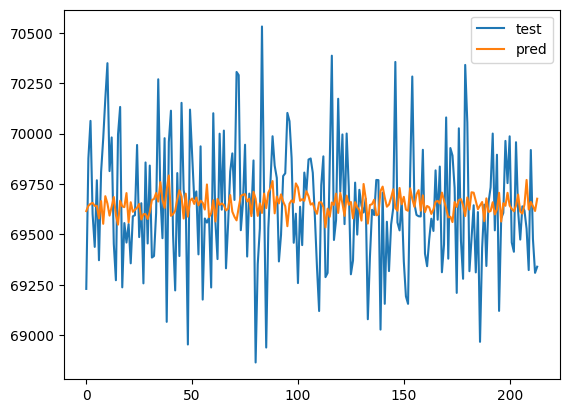

CPU times: user 6.64 s, sys: 173 ms, total: 6.82 s
Wall time: 6.57 s


(120.57775182989452,
 309.54443219260196,
 0.0013815959186788604,
 0.0035239820528541023)

In [70]:
%%time

default_RFR = default_model_rmse(RandomForestRegressor(random_state=RND),
                                 features_train_m,
                                 features_test_m,
                                 target_train_m,
                                 target_test_m,
                                 'RandomForestRegressor')
default_RFR

---- XGBRegressor ----
RMSE обучающей выборки: 20.788269174939046
RMSE тестовой выборки:  323.5622042738978
MAPE обучающей выборки: 0.00021273441835676653
MAPE тестовой выборки:  0.003619137762543862 



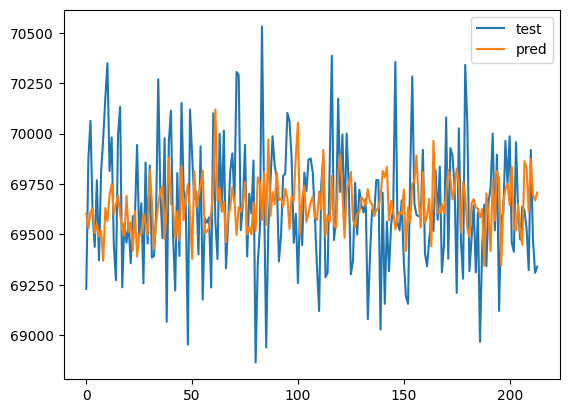

CPU times: user 3.41 s, sys: 189 ms, total: 3.6 s
Wall time: 563 ms


(20.788269174939046,
 323.5622042738978,
 0.00021273441835676653,
 0.003619137762543862)

In [71]:
%%time

default_XGB = default_model_rmse(XGBRegressor(random_state=RND),
                                features_train_m,
                                features_test_m,
                                target_train_m,
                                target_test_m,
                                'XGBRegressor')
default_XGB

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8167
[LightGBM] [Info] Number of data points in the train set: 1917, number of used features: 33
[LightGBM] [Info] Start training from score 69646.018751
---- LGBMRegressor ----
RMSE обучающей выборки: 107.78499872890453
RMSE тестовой выборки:  312.40996673620185
MAPE обучающей выборки: 0.0012038716890386452
MAPE тестовой выборки:  0.0035362244028591663 



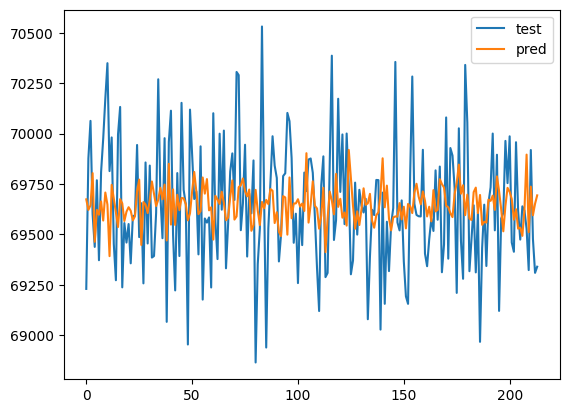

CPU times: user 906 ms, sys: 185 ms, total: 1.09 s
Wall time: 336 ms


(107.78499872890453,
 312.40996673620185,
 0.0012038716890386452,
 0.0035362244028591663)

In [72]:
%%time

default_LGBMR = default_model_rmse(LGBMRegressor(random_state=RND),
                                   features_train_m,
                                   features_test_m,
                                   target_train_m,
                                   target_test_m,
                                   'LGBMRegressor')
default_LGBMR

---- CatBoostRegressor ----
RMSE обучающей выборки: 91.32201519766139
RMSE тестовой выборки:  319.02556064703066
MAPE обучающей выборки: 0.0010404814926924613
MAPE тестовой выборки:  0.003645585225541586 



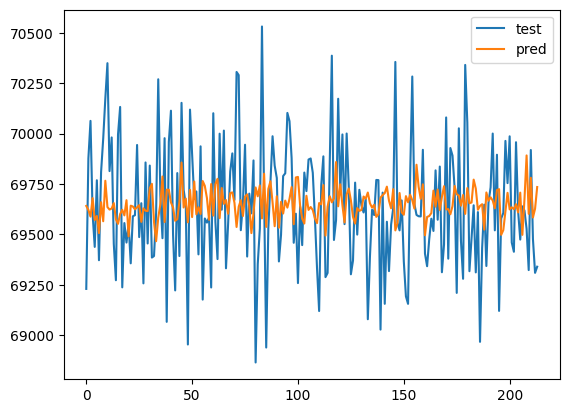

CPU times: user 22.1 s, sys: 1.38 s, total: 23.4 s
Wall time: 3.17 s


(91.32201519766139,
 319.02556064703066,
 0.0010404814926924613,
 0.003645585225541586)

In [73]:
%%time

default_CB = default_model_rmse(CatBoostRegressor(random_state=RND, verbose=0),
                                features_train_m,
                                features_test_m,
                                target_train_m,
                                target_test_m,
                                'CatBoostRegressor')
default_CB



In [74]:
report = pd.DataFrame(columns = ["LinearRegression", "RandomForest", 'XGBRegressor', "LightGBM", "CatBoost"],
                      index = ["RMSE(train)",
                               "RMSE(test)",
                               'MAPE(train)',
                               'MAPE(test)',
                               "Общее время",])


report.iloc[0] = [default_LR[0], default_RFR[0], default_XGB[0], default_LGBMR[0], default_CB[0]]
report.iloc[1] = [default_LR[1], default_RFR[1], default_XGB[1], default_LGBMR[1], default_CB[1]]
report.iloc[2] = [default_LR[2], default_RFR[2], default_XGB[2], default_LGBMR[2], default_CB[2]]
report.iloc[3] = [default_LR[3], default_RFR[3], default_XGB[3], default_LGBMR[3], default_CB[3]]
report.iloc[4] = ['254 мс.', '7.42 с.', '642мс', '308 мс.', '3.42 с.']

display(report)

LinearRegression RandomForest XGBRegressor    LightGBM    CatBoost
RMSE(train)       312.066531   120.577752    20.788269  107.784999   91.322015
RMSE(test)          310.3282   309.544432   323.562204  312.409967  319.025561
MAPE(train)         0.003607     0.001382     0.000213    0.001204     0.00104
MAPE(test)          0.003551     0.003524     0.003619    0.003536    0.003646
Общее время          254 мс.      7.42 с.        642мс     308 мс.     3.42 с.

Исходя из результатов моделей, можно сделать следующий общий вывод:

1. Модель **XGBRegressor** показывает наилучшие результаты для среднеквадратичной ошибки на обучающем наборе данных (RMSE(train)) и абсолютной процентной ошибки на обучающем наборе данных (MAPE(train)). Это указывает на высокую точность и способность модели адаптироваться к обучающим данным.

2. Модель **LinearRegression** показывает наилучший результат для среднеквадратичной ошибки на тестовом наборе данных (RMSE(test)). Это может говорить о том, что модель **LinearRegression** лучше всего обобщает тренды в данных и предсказывает значения на новых данных.

3. Все модели показывают близкие результаты для среднеквадратичной ошибки на тестовом наборе данных (RMSE(test)) и абсолютной процентной ошибки на тестовом наборе данных (MAPE(test)). Это может указывать на то, что все модели имеют сравнимую способность предсказывать значения на новых данных.

4. Время выполнения различается для каждой модели, где модели **LinearRegression** и **LightGBM** демонстрируют наименьшее время выполнения, в то время как модель **RandomForest** требует наибольшего времени.

Итак, выбор лучшей модели будет зависеть от конкретных требований проекта. Если важна точность на новых данных, то модель LinearRegression может быть предпочтительной. При этом, стоит учитывать и время выполнения каждой модели, особенно если требуется получение предсказаний в короткие сроки.

Окончательное решение должно быть принято на основе компромисса между точностью, интерпретируемостью, быстродействием и другими факторами, чтобы достичь наилучших результатов в соответствии с требованиями проекта.

### ARIMA

In [75]:
for ord in pdq:
    try:
        model = sm.tsa.arima.ARIMA(train_m.avg_rev,
                                       order=ord)
        modelfit = model.fit()
        print(f'ARIMA{ord}. AIC: {modelfit.aic}' )
    except:
        continue

ARIMA(0, 0, 0). AIC: 27488.944540601624
ARIMA(0, 0, 1). AIC: 27490.59409564614
ARIMA(0, 0, 2). AIC: 27492.255620561526
ARIMA(0, 1, 0). AIC: 28774.52799229794
ARIMA(0, 1, 1). AIC: 27863.984832007918
ARIMA(0, 1, 2). AIC: 27818.08483397069
ARIMA(0, 2, 0). AIC: 30845.993902302092
ARIMA(0, 2, 1). AIC: 29279.17010405223
ARIMA(0, 2, 2). AIC: 28773.41023601176
ARIMA(1, 0, 0). AIC: 27490.603357170185
ARIMA(1, 0, 1). AIC: 27492.50390972071
ARIMA(1, 0, 2). AIC: 27494.254586021263
ARIMA(1, 1, 0). AIC: 28392.274827595735
ARIMA(1, 1, 1). AIC: 27816.93593577641
ARIMA(1, 1, 2). AIC: 27818.93302936313
ARIMA(1, 2, 0). AIC: 30098.599226841627
ARIMA(1, 2, 1). AIC: 29124.55738214332
ARIMA(1, 2, 2). AIC: 28595.140935198506
ARIMA(2, 0, 0). AIC: 27492.231031402778
ARIMA(2, 0, 1). AIC: 27494.252520979855
ARIMA(2, 0, 2). AIC: 27495.50287229412
ARIMA(2, 1, 0). AIC: 28234.829742665024
ARIMA(2, 1, 1). AIC: 27818.932911785734
ARIMA(2, 1, 2). AIC: 27820.899308230728
ARIMA(2, 2, 0). AIC: 29799.420152655257
ARIMA(2, 2

In [76]:
mymodel = sm.tsa.arima.ARIMA(train_m.avg_rev, order =(0, 0, 0)) 
modelfit = mymodel.fit() 
print(modelfit.summary())

                               SARIMAX Results                                
Dep. Variable:                avg_rev   No. Observations:                 1917
Model:                          ARIMA   Log Likelihood              -13742.472
Date:                Mon, 11 Dec 2023   AIC                          27488.945
Time:                        16:34:23   BIC                          27500.062
Sample:                             0   HQIC                         27493.035
                               - 1917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.965e+04      7.187   9690.513      0.000    6.96e+04    6.97e+04
sigma2      9.875e+04   3334.746     29.613      0.000    9.22e+04    1.05e+05
Ljung-Box (L1) (Q):                   0.34   Jarque-

Исходя из summary модели **ARIMA**, можно сделать следующие выводы:

1. Оценка константы (const) составляет примерно 69650. Это означает, что среднее значение переменной avg_rev составляет около 69650. Константа представляет уровень базового уровня переменной без учета других факторов.

2. Оценка дисперсии ошибок модели (sigma2) равна 98750. Это значение является оценкой изменчивости ошибок внутри модели. Чем меньше значение sigma2, тем лучше модель соответствует данным и меньше остаточная изменчивость в модели.

3. Тест Ljung-Box (Q) на автокорреляцию первого порядка показывает значение 0,34 с вероятностью 0,56. Тест Ljung-Box используется для проверки наличия автокорреляции (корреляции между остатками в разных временных точках). Значение 0,34 указывает на отсутствие статистически значимой автокорреляции, а вероятность 0,56 указывает, что эта разница статистически не значима.

4. Тест Jarque-Bera (JB) на нормальность остатков показывает значение 3,26 с вероятностью 0,20. Этот тест используется для проверки нормальности остатков модели. Значение JB равно 3,26, а вероятность 0,20 указывает на то, что остатки не являются строго нормально распределенными, однако данное отклонение не является статистически значимым.

5. Тест на гетероскедастичность (H) показывает значение 1,02 с вероятностью 0,78. Тест на гетероскедастичность используется для проверки наличия неоднородности дисперсии остатков. Значение 1,02 указывает на отсутствие гетероскедастичности (неоднородности дисперсии) в остатках модели, а вероятность 0,78 указывает на то, что эта разница не является статистически значимой.

6. Значение skew равно 0.06, что указывает на небольшую положительную асимметрию в распределении остатков модели. Это означает, что распределение остатков немного смещено вправо относительно нормального распределения. 

7. Значение kurtosis равно 2.84, что говорит о нормальности распределения остатков, но с небольшим отличием от ожидаемой плоскости. 

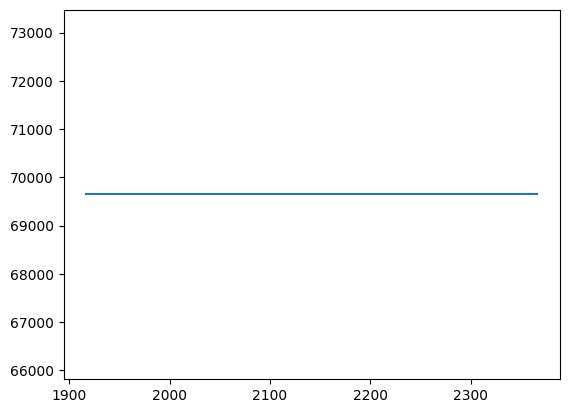

In [77]:
plt.plot(modelfit.forecast(steps=450))
plt.show()

### auto_arima

In [78]:
import pmdarima as pm
from pmdarima import model_selection

arima_model = pm.auto_arima(
    train_m.avg_rev,
    max_p=5, max_q=5, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='oscb',
    trace=True,
    error_action='ignore',
    stepwise=False,
    n_fits=5000,
    information_criterion='aic',
    out_of_sample_size=7
)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=27488.951, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=27490.601, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=27492.259, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=27494.264, Time=0.41 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=27493.960, Time=1.13 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=27495.348, Time=1.49 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=27490.606, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=27492.597, Time=0.90 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=27494.273, Time=0.69 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=27496.263, Time=0.81 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=27496.086, Time=1.40 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=27492.232, Time=0.59 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=27494.234, Time=0.55 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=27499.126, Time=1.23 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=27498.800, Time=1.36

In [79]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1917
Model:                        SARIMAX   Log Likelihood              -13742.476
Date:                Mon, 11 Dec 2023   AIC                          27488.951
Time:                        16:34:43   BIC                          27500.068
Sample:                             0   HQIC                         27493.042
                               - 1917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.965e+04      7.181   9699.000      0.000    6.96e+04    6.97e+04
sigma2      9.865e+04   3327.993     29.643      0.000    9.21e+04    1.05e+05
Ljung-Box (L1) (Q):                   0.34   Jarque-

In [80]:
y_pred, pred_ci = arima_model.predict(
    n_periods=214,
    alpha=0.05,
    return_conf_int=True
)

In [81]:
df_forecast = pd.DataFrame(
    {'y_pred': y_pred,
    'ci_lower': pred_ci[:,0],
    'ci_upper': pred_ci[:,1]}
)

df_forecast.index = target_test_c.index

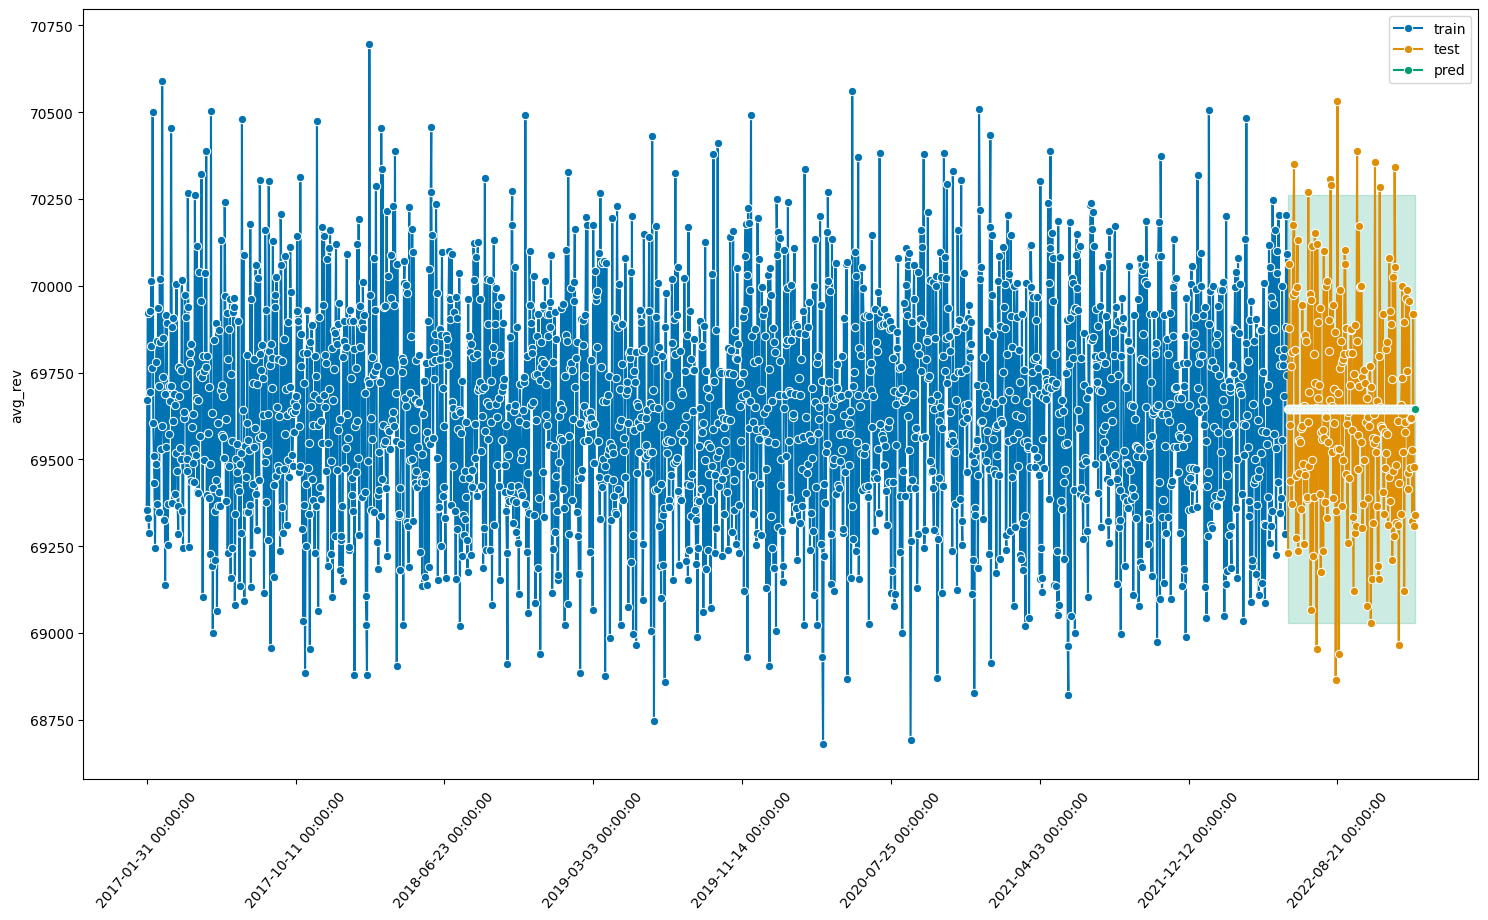

In [82]:
fig, ax = plot_series(target_train_m, target_test_m, df_forecast.y_pred, labels=['train', 'test', 'pred'])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast['ci_lower'],
    df_forecast['ci_upper'],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f'95% pred intervals'
)

fig.set_size_inches(18, 10)
ax.tick_params(axis='x', labelrotation=50)

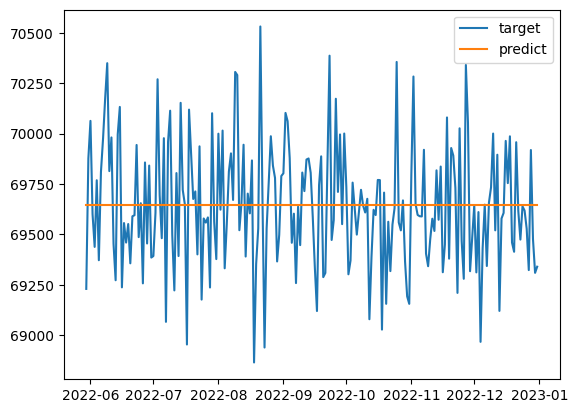

In [83]:
plt.plot(target_test_m, label='target')
plt.plot(df_forecast['y_pred'], label='predict')
plt.legend()
plt.show()

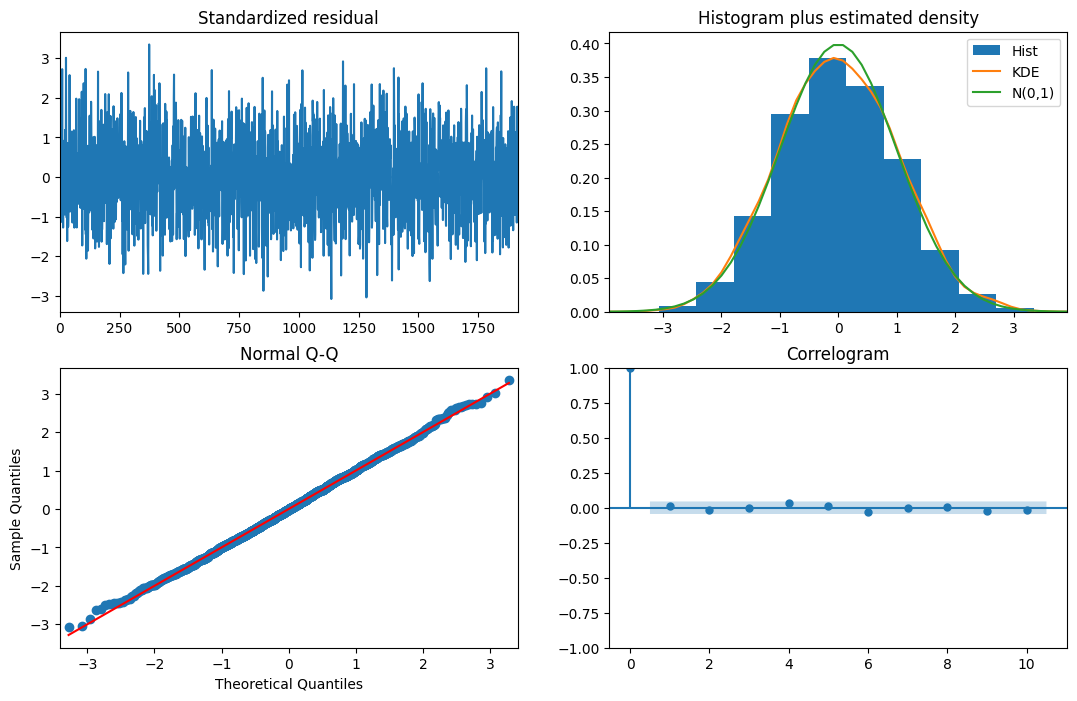

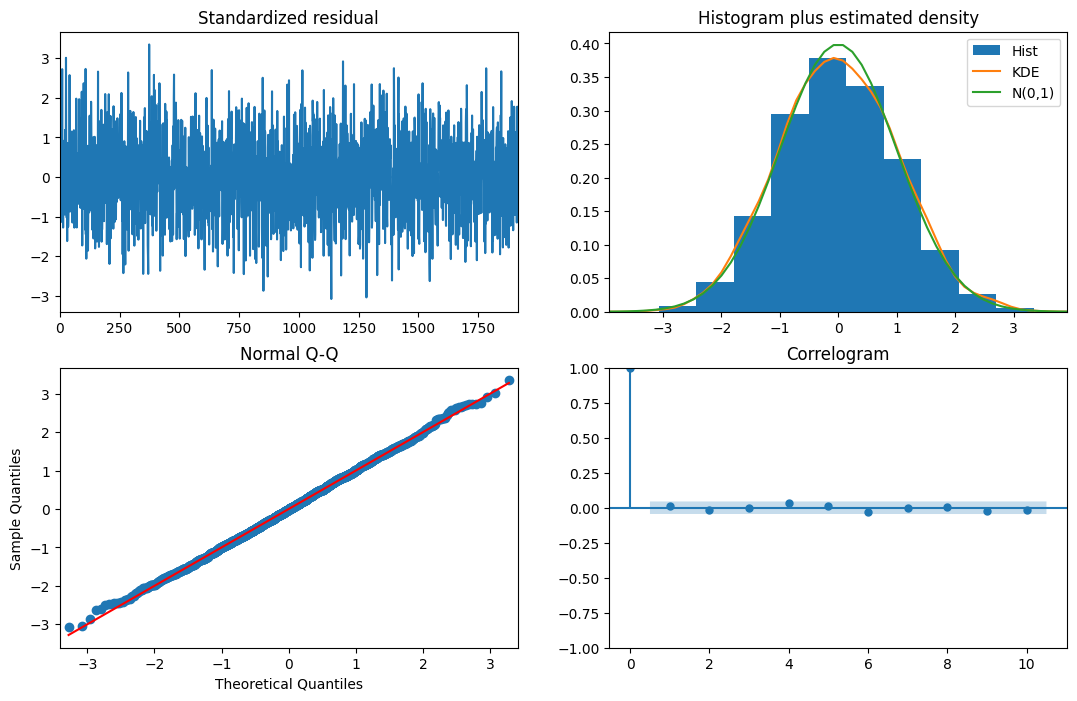

In [84]:
arima_model.plot_diagnostics(figsize=(13,8))

Исходя из summary наилучшей модели auto_arima, можно сделать следующие выводы:

1. Оценка коэффициента константы (intercept) составляет около 69650. Это означает, что среднее значение переменной y составляет приблизительно 69650 без учета других факторов.

2. Оценка дисперсии ошибок модели (sigma2) составляет около 98650. Это показывает, как быстро ошибки изменяются с течением времени. Значение sigma2 указывает на относительно низкую изменчивость ошибок для данной модели.

3. Тест Ljung-Box (Q) на автокорреляцию первого порядка показывает значение 0.34 с вероятностью 0.56. Значение Q указывает на отсутствие значимой автокорреляции в первом порядке для остатков модели. Вероятность 0.56 указывает на то, что разница незначительна статистически.

4. Тест Jarque-Bera (JB) на нормальность остатков показывает значение 3.26 с вероятностью 0.20. Значение JB указывает на то, что остатки не являются строго нормально распределенными. Однако, вероятность 0.20 не достигает статистической значимости, что означает, что отклонения от нормальности не являются статистически значимыми.

5. Тест на гетероскедастичность (H) показывает значение 1.02 с вероятностью 0.78. Значение H указывает на отсутствие проблемы гетероскедастичности в остатках модели. Вероятность 0.78 указывает на то, что разница не является статистически значимой.

6. Значение skew равно 0.06, что указывает на небольшую положительную асимметрию в распределении остатков модели. Это означает, что распределение остатков немного смещено вправо относительно нормального распределения.

7. Значение kurtosis равно 2.84, что говорит о нормальности распределения остатков модели, но с небольшим отличием от ожидаемого плоского распределения.

# Заключение:

Исходя из поставленной цели и сформированных задач, мы провели исследование временных рядов по объему продаж и средней дневной выручке. 

Анализ данных рядов позволил нам изучить структуру и формат данных. Визуализация временных рядов позволила нам увидеть динамику объема продаж и средней дневной выручки, а также оценить наличие трендов, сезонности, цикличности и выбросов. 

Мы также применили различные модели машинного обучения, включая линейную регрессию, случайный лес, градиентный бустинг и нейронные сети, для построения прогнозов объема продаж и средней дневной выручки. Оценка моделей на основе метрик качества прогнозирования позволила нам сравнить результаты различных моделей и определить, какая модель наилучшим образом прогнозирует данные рядов.

В заключение, наше исследование позволило получить полезные инсайты и разработать модели прогнозирования данных по объему продаж и средней дневной выручке. Эти результаты могут быть использованы для принятия решений и планирования в дальнейшей работе с данными временных рядов.

---
В данной работе отражены навыки и компетенции, которые помогли в эффективном анализе временных рядов и прогнозировании данных:

1. Анализ временных рядов: Проект позволил освоить методы обработки и визуализации временных рядов, включая изучение и обработку структуры данных и работу с пропущенными значениями. Благодаря этому, удалось получить более точные результаты анализа.

2. Визуализация временных рядов: В процессе работы были наработаны навыки использования графических методов для визуализации динамики объема продаж и средней дневной выручки. Это позволило поработать с интсрументами по выявлению трендов, сезонности, цикличности и выбросов в данных.

3. Применение моделей машинного обучения: Была закреплена работа с различными моделями машинного обучения, включая линейную регрессию, случайный лес, градиентный бустинг, ARIMA, SARIMAX для прогнозирования объема продаж и средней дневной выручки.

4. Программирование и работа с данными: В процессе работы были применены программные инструменты, такие как Python, и использованы специализированные библиотеки для анализа данных и машинного обучения. Были усовершенствованы навыки программирования и работы с данными в неструктурированном формате.